<a href="https://colab.research.google.com/github/JanullaPolasko/Prediction-of-music-popularity/blob/main/codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

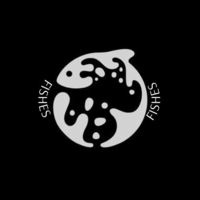
<h1><strong><center>Tema 4: Popularita hudby<strong/></h1>


---
<h3>Tím Fishes: Trapped in a neural network:</h3>

- Zuzana Kováčová
- Kristína Galková
- Jana Poľašková
- Simona Bednáriková


---
Odbor: DAV





In [1]:
# @title Import knižníc
import kagglehub
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    mean_squared_error, r2_score, accuracy_score,
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)

from sklearn import preprocessing
from sklearn.preprocessing import (
    StandardScaler, PolynomialFeatures, PowerTransformer,
    LabelEncoder
)

from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

from tabulate import tabulate
from scipy.stats import spearmanr

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from yellowbrick.model_selection import FeatureImportances
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#1.  Datasety

Pre analýzu sme zvolili dataset zo stránky Kaggle (https://www.kaggle.com/datasets/tomigelo/spotify-audio-features), ktorý obsahuje až 17 premenných umožňujúcich analyzovať faktory ovplyvňujúce popularitu skladieb. Dataset je dostatočne rozsiahly, obsahuje 130 325 záznamov, čo by mohlo zvýšiť presnosť a spoľahlivosť výsledkov našej analýzy. Popisy jednotlivých premenných sme doplnili informáciami z oficiálnej stránky Spotify.



Okrem základného datasetu sme použili aj druhý zdroj (https://kworb.net/spotify/artists.html?fbclid=IwZXh0bgNhZW0CMTEAAR2Bj_U0gmgjHBn6Jt3GguG1NYRDpiOLfWvMPkm4bsX1qQZp67yvIKbOv5E_aem_VB5DyAuSgFdu2WpySSbD0Q), ktorý sa zameriava na hodnotenie popularity jednotlivých interpretov na Spotify. Tento zdroj sme vybrali na základe predpokladu, že popularita skladby úzko súvisí s popularitou interpreta. Aby sme mohli interpretov reprezentovať kvantitatívnou premennou namiesto kategórie (mena interpreta), priradili sme im hodnotu popularity na základe počtu streamov.
Tento dataset obsahuje 3 000 najpopulárnejších interpretov, zoradených podľa celkového počtu prehratí. Interpretom sme priradili pozíciu v rebríčku zoradenom vzostupne – najpopulárnejší interpret získal hodnotu 3 000, zatiaľ čo menej populárni interpreti nižšie hodnoty.

Následne sme oba datasety spojili a obmedzili analýzu len na skladby interpretov, ktorí sa nachádzali v top 3 000. Po odstránení duplicít v stĺpci track_id (identifikátor pesničky) sme pracovali s celkovým počtom 29 281 záznamov.

Aby sme mohli pesničku označiť ako populárnu, respektíve nepopulárnu, rozhodli sme sa pracovať s hodnotou popularity ako binárnou premennou. Za prahovú hodnotu sme zvolili 75% kvantil popularity, ktorý má hodnotu 53. Skladby s hodnotou popularity vyššou alebo rovnou 53 sme označili za populárne (top 25%). Týmto spôsobom sme získali základ pre klasifikačné metódy.

In [2]:
# @title Načítanie základných dát
path = kagglehub.dataset_download("tomigelo/spotify-audio-features")
print("Path to dataset files:", path)

100%|██████████| 17.4M/17.4M [00:01<00:00, 11.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tomigelo/spotify-audio-features/versions/3


In [3]:
dataset_path = '/root/.cache/kagglehub/datasets/tomigelo/spotify-audio-features/versions/3/SpotifyAudioFeaturesApril2019.csv'
df_withoutRanks = pd.read_csv(dataset_path)

In [4]:
# @title Načítanie dát na hodnotenie interpretov
url = 'https://raw.githubusercontent.com/JanullaPolasko/Prediction-of-music-popularity/main/artist_rank%20(1).xlsx'
artist_streams = pd.read_excel(url, engine='openpyxl')
artist_streams['artist_rank'] = artist_streams['Streams'].rank(ascending=True, method='min')

In [5]:
# @title Merge oboch tabuliek
df = pd.merge(df_withoutRanks, artist_streams , left_on='artist_name', right_on='Artist', how='inner')
df = df.drop(columns=[ 'Daily', 'As lead', 'Solo', 'As feature', 'Streams', 'Artist'])

In [6]:
# @title Čistenie dát a odstránenie duplicít
initial_row_count = df.shape[0]

# Duplicity
df = df.drop_duplicates(subset=['track_id'], keep='first').copy()

final_row_count = df.shape[0]
removed = initial_row_count - final_row_count
print("Počet odstránených riadkov:", removed)
print("Aktuálny počet záznamov:", final_row_count)


Počet odstránených riadkov: 165
Aktuálny počet záznamov: 29281


In [7]:
# @title Definícia popularity ako binárna hodnota
quantile_75 = df['popularity'].quantile(0.75)
df['popularity_bin'] = np.where(df['popularity'] >= quantile_75, 1, 0)   ###50
print(f"75% kvantil popularity = {quantile_75}")

75% kvantil popularity = 53.0


In [8]:
# @title Rozdelenie na trénovaciu a testovaciu vzorku - veľkosť trénovacej vzorky je 80% z celkového počtu záznamov.
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print("Velkost trénovacej množiny:", train_df.shape)
print("Velkost testovacej množiny:", test_df.shape)

Velkost trénovacej množiny: (23424, 19)
Velkost testovacej množiny: (5857, 19)


# 2. Štatistiky a Vizualizácia

In [ ]:
# @title Deskriptívne štatistiky
descriptive_stats = train_df.describe()
print(descriptive_stats)

       acousticness  danceability   duration_ms        energy  \
count  23424.000000  23424.000000  2.342400e+04  23424.000000   
mean       0.445577      0.542505  2.194191e+05      0.499197   
std        0.385243      0.201931  1.221714e+05      0.283167   
min        0.000001      0.000000  3.677000e+03      0.000020   
25%        0.064000      0.390000  1.638335e+05      0.238000   
50%        0.334000      0.557000  2.039330e+05      0.546000   
75%        0.885000      0.702000  2.482790e+05      0.732000   
max        0.996000      0.981000  2.791933e+06      0.999000   

       instrumentalness           key      liveness      loudness  \
count      23424.000000  23424.000000  23424.000000  23424.000000   
mean           0.194195      5.215676      0.207674    -11.481054   
std            0.344853      3.574712      0.187434      7.786862   
min            0.000000      0.000000      0.000000    -46.507000   
25%            0.000000      2.000000      0.098100    -16.626250   


## Vysvetlenie a popis deskriptívnych štatistík jednotlivých premenných:

1. **Popularita**:
   Priemerná popularita je **24.10**, čo naznačuje, že dataset obsahuje prevažne skladby s nižšou popularitou.
   Hodnoty sa pohybujú od **0** (najmenej populárne) po **100** (najviac populárne), čo je očakávaná škála popularity.

2. **Dĺžka skladieb**:
   Priemerná dĺžka skladieb je **212433.5 ms** (približne **3 minúty 32 sekúnd**).
   Rozptyl hodnôt je veľký, pričom maximálna dĺžka dosahuje až **5610020 ms** (~93 minút), čo poukazuje na výskyt extrémnych hodnôt.

3. **Danceability**:
   Táto metrika ukazuje, ako vhodná je skladba na tanec. Priemerná hodnota je **0.342**, čo naznačuje, že skladby sú prevažne menej tancovateľné, s miernou variabilitou v tomto ohľade.

4. **Energia**:
   Priemerná energia skladieb je **0.569**, čo naznačuje stredne vysokú úroveň energie, s variabilitou od tichých skladieb po energické.

5. **Hlasitosť (loudness)**:
   Priemerná hlasitosť skladieb je **-9.97 dBFS**, s rozsahom od **-60.00** po **1.81 dBFS**. Hodnoty pod nulou sú bežné pre digitálne nahrávky.

6. **Speechiness**:
   Priemerná hodnota je **0.112**. Ak hodnota presiahne **0.66**, skladba pozostáva prevažne z hovoreného slova (napr. podcasty).

7. **Acousticness**:
   Priemerná hodnota je **0.315**, čo naznačuje, že väčšina skladieb v datasete nie je veľmi akustická a je viac syntetická.

8. **Inštrumentálnosť (instrumentalness)**:
   Väčšina skladieb nemá výrazné inštrumentálne časti (medián = **0.000**), pričom maximálna hodnota je **1.000**. Čím je hodnota inštrumentálnosti bližšie k 1.0, tým väčšia je pravdepodobnosť, že skladba neobsahuje žiadny vokálny obsah.

9. **Tempo**:
   Priemerné tempo je **119.49 BPM**, čo je mierne nižšie ako typické pre väčšinu populárnych skladieb, ktoré sa zvyčajne pohybujú okolo 120 BPM.

10. **Valence**:
   Táto premenná popisuje **hudobnú pozitivitu**. Skladby s vysokou valenciou znejú **pozitívnejšie** (napr. veselšie, euforické), zatiaľ čo skladby s nízkou valenciou sa javia ako **negatívnejšie** (napr. smutné, depresívne, nahnevané).
   Priemerná hodnota valencie v našom datasete je **0.439**, čo znamená, že sa v ňom nachádzajú skladby s rôznymi náladami.


In [ ]:
# @title Top 5 populárnych skladieb
top_5_popular = train_df.sort_values(by='popularity', ascending=False).head(5)

print(tabulate(top_5_popular, headers='keys', tablefmt='grid'))

+-------+----------------+------------------------+-----------------------------------------------+----------------+----------------+---------------+----------+--------------------+-------+------------+------------+--------+---------------+---------+------------------+-----------+--------------+---------------+------------------+
|       | artist_name    | track_id               | track_name                                    |   acousticness |   danceability |   duration_ms |   energy |   instrumentalness |   key |   liveness |   loudness |   mode |   speechiness |   tempo |   time_signature |   valence |   popularity |   artist_rank |   popularity_bin |
+=======+================+========================+===============================================+================+================+===============+==========+====================+=======+============+============+========+===============+=========+==================+===========+==============+===============+==================+
| 12

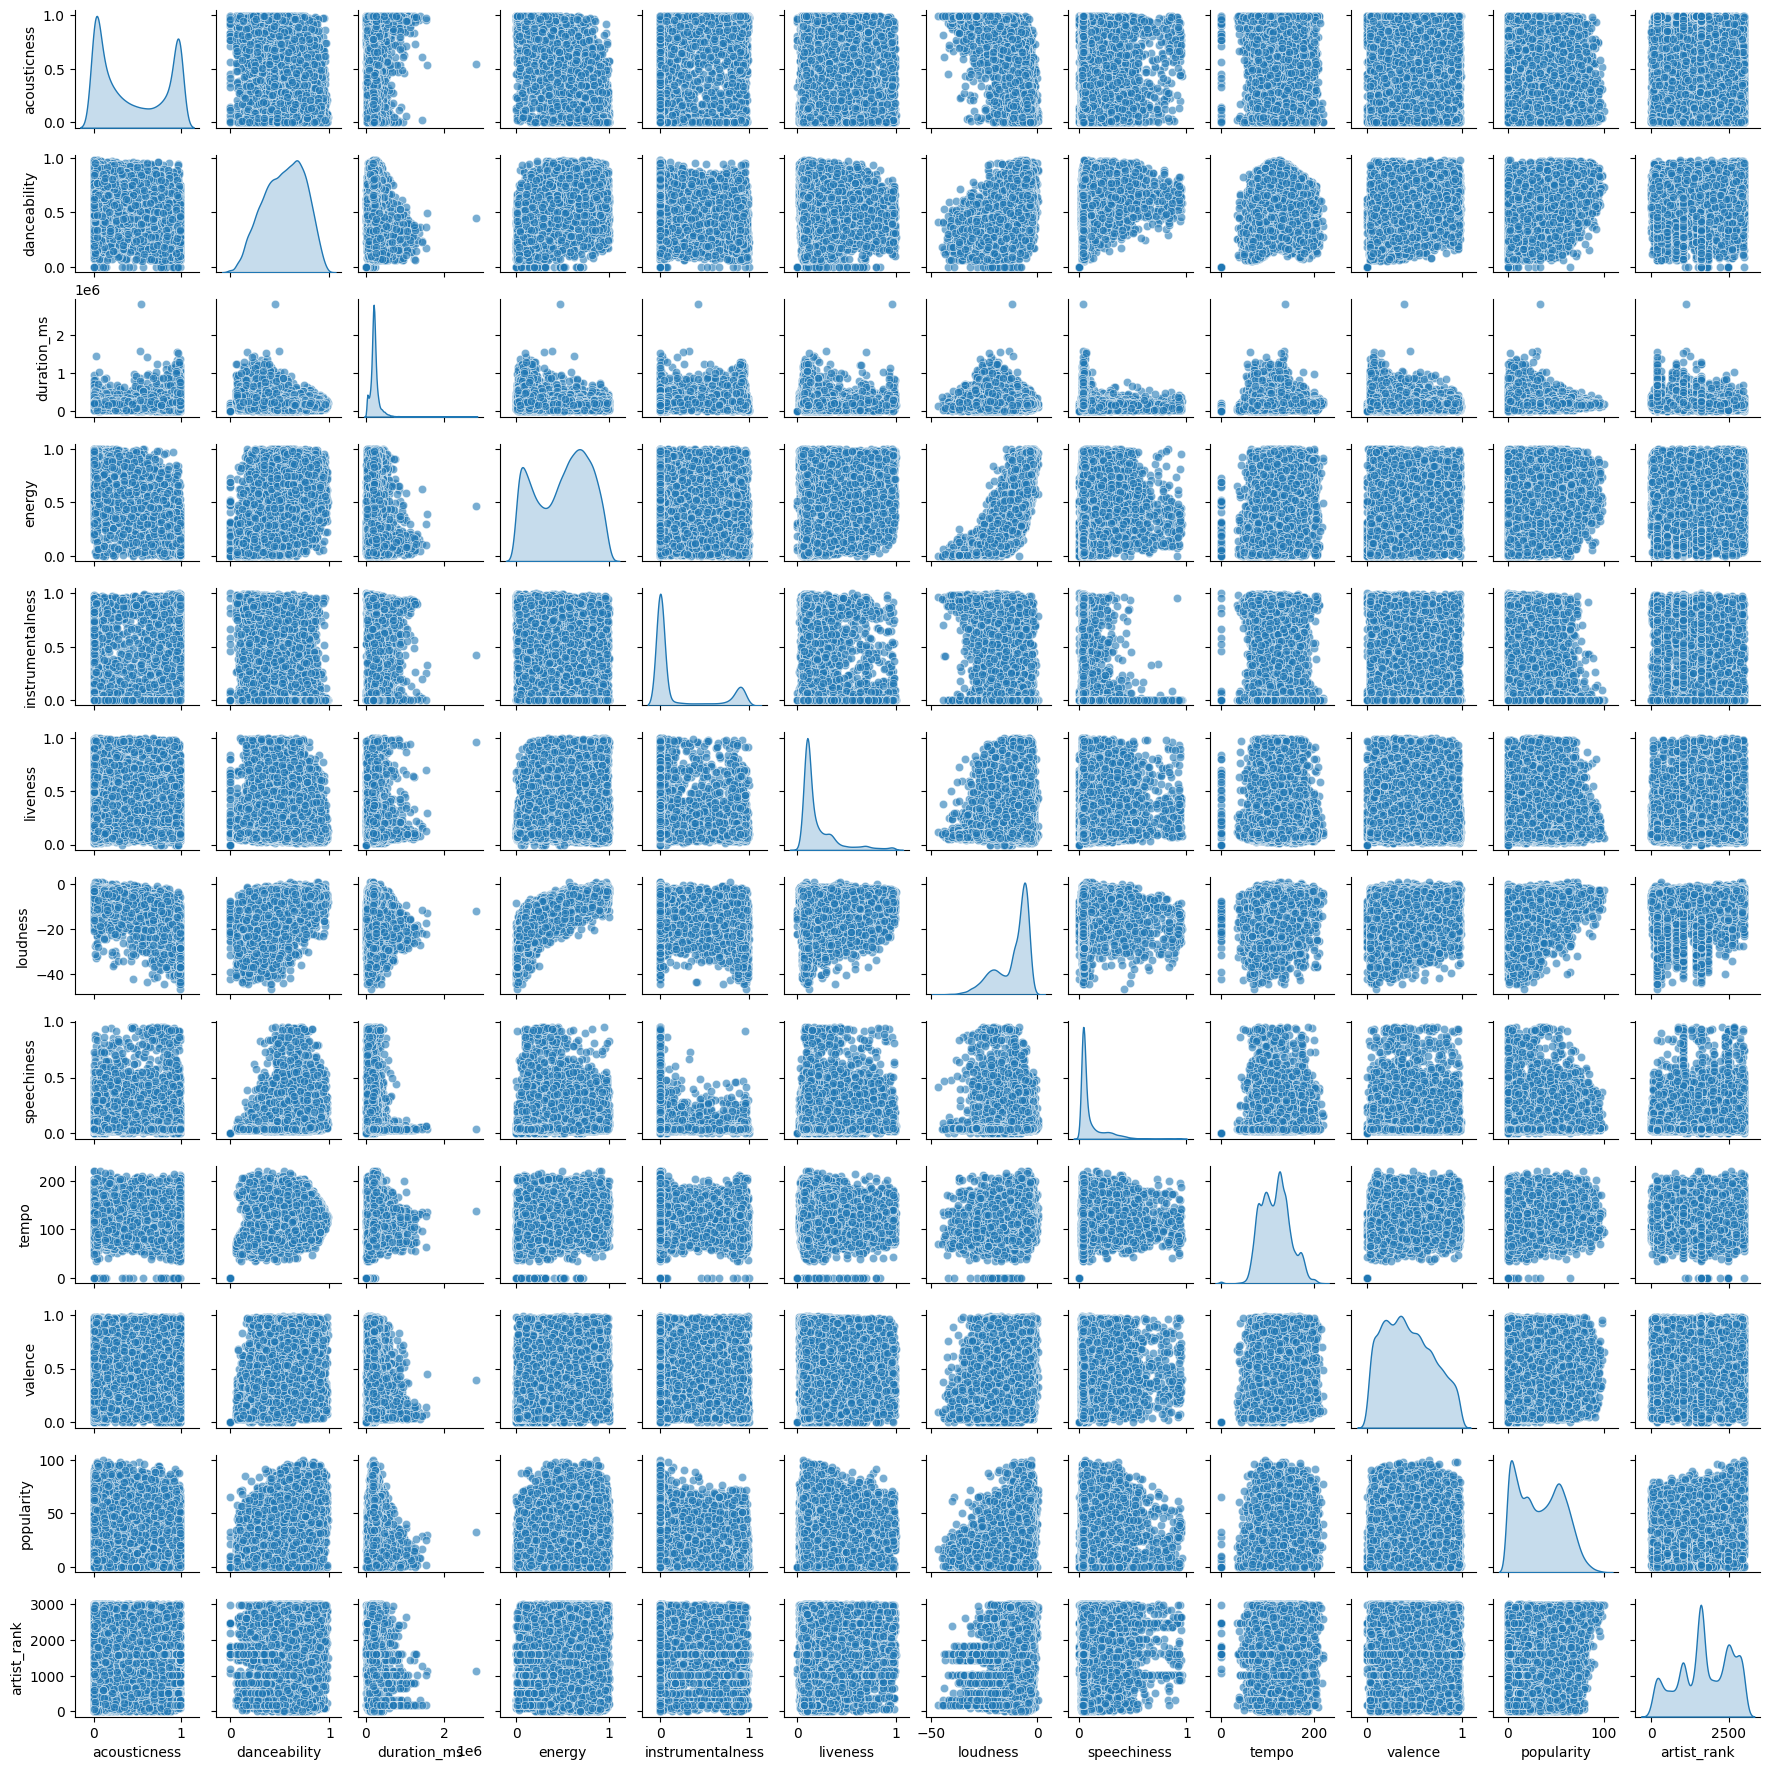

In [ ]:
# @title Pairplot s hustotou pre kvantitatívne premenné
# ak sa ponahlade tak to nespustajte
kvant = train_df.drop(columns=['key', 'mode', 'time_signature', 'popularity_bin'])

sns.pairplot(kvant, diag_kind='kde', height=1.5, plot_kws={'alpha': 0.6})
plt.show()

## Popis barplotu
***Hustotné grafy na diagonále:***\
Z grafov vidno, ako sú rozložené jednotlivé premenné:
* loudness: Má špecifické ľavostranné rozloženie, čo naznačuje, že väčšina hodnôt je sústredená na nižšej hlasitosti.
* speechiness: Má rozloženie blízke logaritmickému – väčšina hodnôt je sústredená pri nízkych hodnotách.
* duration_ms: Mierne pravošikmé rozloženie – dlhšie skladby sú menej časté.
popularity: Hodnoty sú rozložené rovnomerne.

***Scatter ploty mimo diagonály:***
* Väčšina bodov je rovnomerne roztrúsená, čo znamená, že nie je silná lineárna korelácia medzi premennými.

***Vzorce a korelácie, ktoré pozorujeme***
* loudness vs. energy: Je vidieť mierny pozitívny vzťah – skladby s vyššou energiou majú tendenciu byť hlasnejšie.


**Záver**
Väčšina premenných nemá silnú koreláciu, čo naznačuje, že sú nezávislé alebo majú zložitejší vzťah.


#Čo to môže znamenať pre naše modely

***1. Lineárna regresia:***

Vzhľadom na slabú alebo žiadnu lineárnu koreláciu medzi väčšinou premenných môže byť predikčná presnosť nízka.
Premenné ako loudness vs. energy by mohli mať určitý pozitívny lineárny vzťah, čo môže zlepšiť výkon pri vhodnej predspracovanej regresii.

***2. Logistická regresia:***

Ak cieľovú premennú kategorizujeme (napr. binárna premenná úspešná = 1/neúspešná skladba = 0), model môže mať problémy, keďže prediktory majú slabé vzťahy alebo sú rozdelené nerovnomerne.
Zároveň však diskrétne premenné (napr. key a mode) môžu pomôcť lepšie klasifikovať kategórie.

***3. Rozhodovací strom:***

Model by mal zvládnuť diskrétne aj spojité premenné a nebude ovplyvnený slabou linearitou.
Premenné s diskrétnymi hodnotami ako time_signature alebo mode budú vhodné na rozdelenie dát v stromovej štruktúre.

***4. KNN algoritmus:***

KNN bude citlivý na husté oblasti dát (napr. zhustené pri nízkych hodnotách speechiness), čo môže ovplyvniť výkon.
Pre efektívny výsledok bude potrebná normalizácia alebo škálovanie dát, pretože niektoré premenné majú veľmi odlišné rozsahy hodnôt .

# 3. Analýza popularity a jej vzťahov s ostatnými premennými

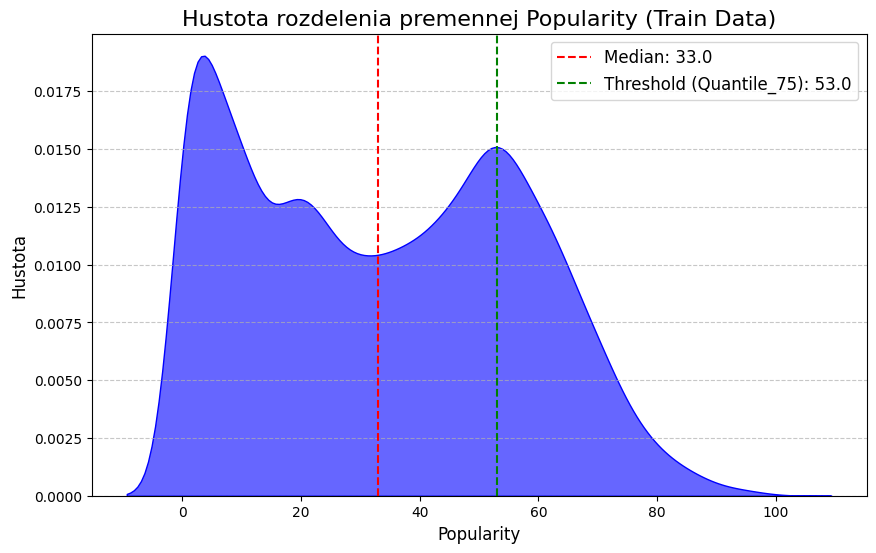

In [ ]:
# @title Hustota rozdelenia popularity
median_popularity = train_df['popularity'].median()
quantile_75 = df['popularity'].quantile(0.75)

plt.figure(figsize=(10, 6))
sns.kdeplot(train_df['popularity'], fill=True, color="blue", alpha=0.6)
plt.axvline(median_popularity, color='red', linestyle='--', label=f'Median: {median_popularity}')
plt.axvline(quantile_75, color='green', linestyle='--', label=f'Threshold (Quantile_75): {quantile_75}')
plt.title('Hustota rozdelenia premennej Popularity (Train Data)', fontsize=16)
plt.xlabel('Popularity', fontsize=12)
plt.ylabel('Hustota', fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Na grafe môžeme vidieť, že naša premenná „popularity“ nie je rovnomerne rozdelená. V dátach výrazne prevažujú skladby s nižšou popularitou, čo môže predstavovať problém. Model by sa mohol viac prispôsobiť skladbám s nižšou popularitou, pričom skladby s vyššou popularitou by mohli byť preň náročné na identifikáciu.

Aj z tohto dôvodu sme sa rozhodli do datasetu pridať ďalší stĺpec, v ktorom budú skladby klasifikované ako populárne a nepopulárne. Po viacerých diskusiách o tom, ako spravodlivo rozdeliť tieto dáta, sme sa nakoniec rozhodli použiť 75% kvantil ako hranicu na rozdelenie skladieb (viď na obrázku).








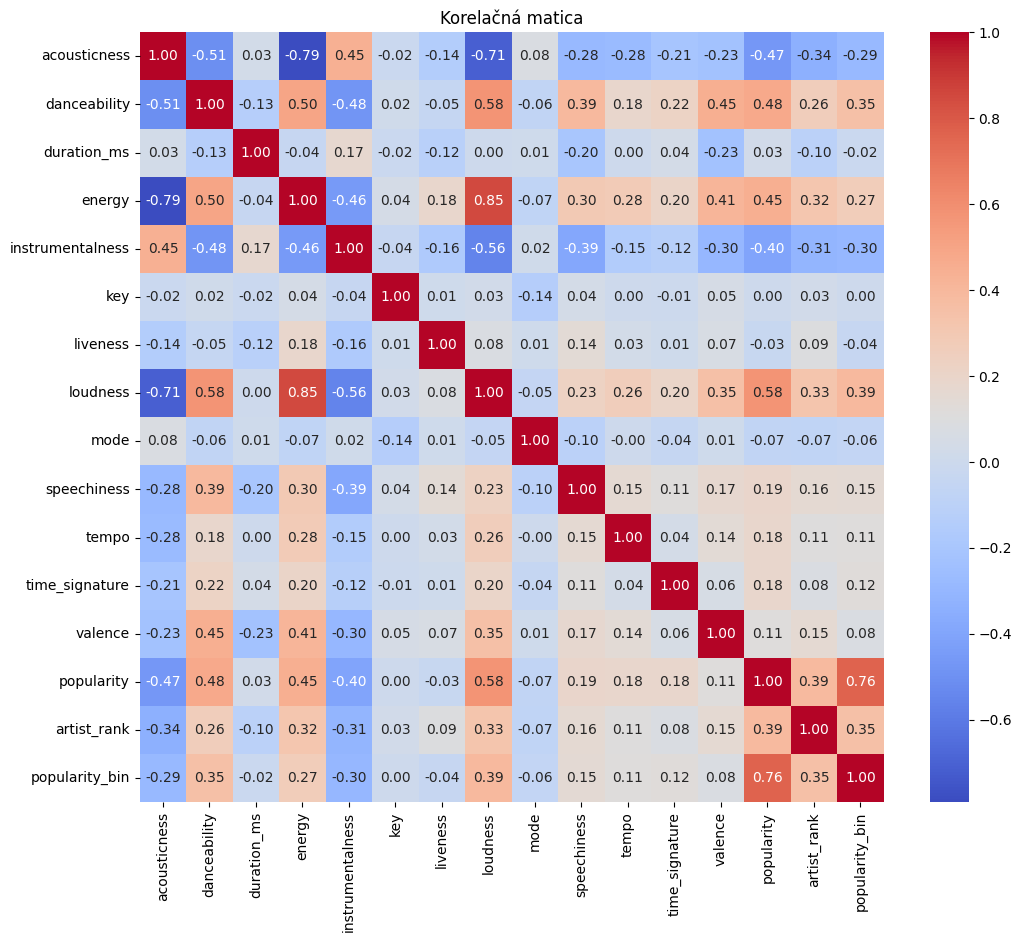

In [ ]:
## @title Korelácia

numerical_columns = train_df.select_dtypes(include=['number'])

plt.figure(figsize=(12, 10))
sns.heatmap(numerical_columns.corr(method='spearman'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelačná matica')
plt.show()

Rozhodli sme sa použiť Spearmanovu koreláciu, pretože dáta vykazujú nelineárne vzťahy, pri ktorých Spearman poskytuje lepšie výsledky.

Pri premennej popularity sme zaznamenali viaceré výrazné korelácie. Pozitívnu koreláciu môžeme vidieť s premennými, ako sú danceability, energy, loudness a artist_rank. Naopak, negatívnu koreláciu pozorujeme pri acousticness a instrumentalness. Závislosť s premennou popularity_bin je prirodzená, keďže sme túto premennú vytvorili na základe popularity.

Na vyššie spomínané premenné, pri ktorých sme pozorovali výraznejšie hodnoty korelácie, sme sa ďalej podrobnejšie zamerali.


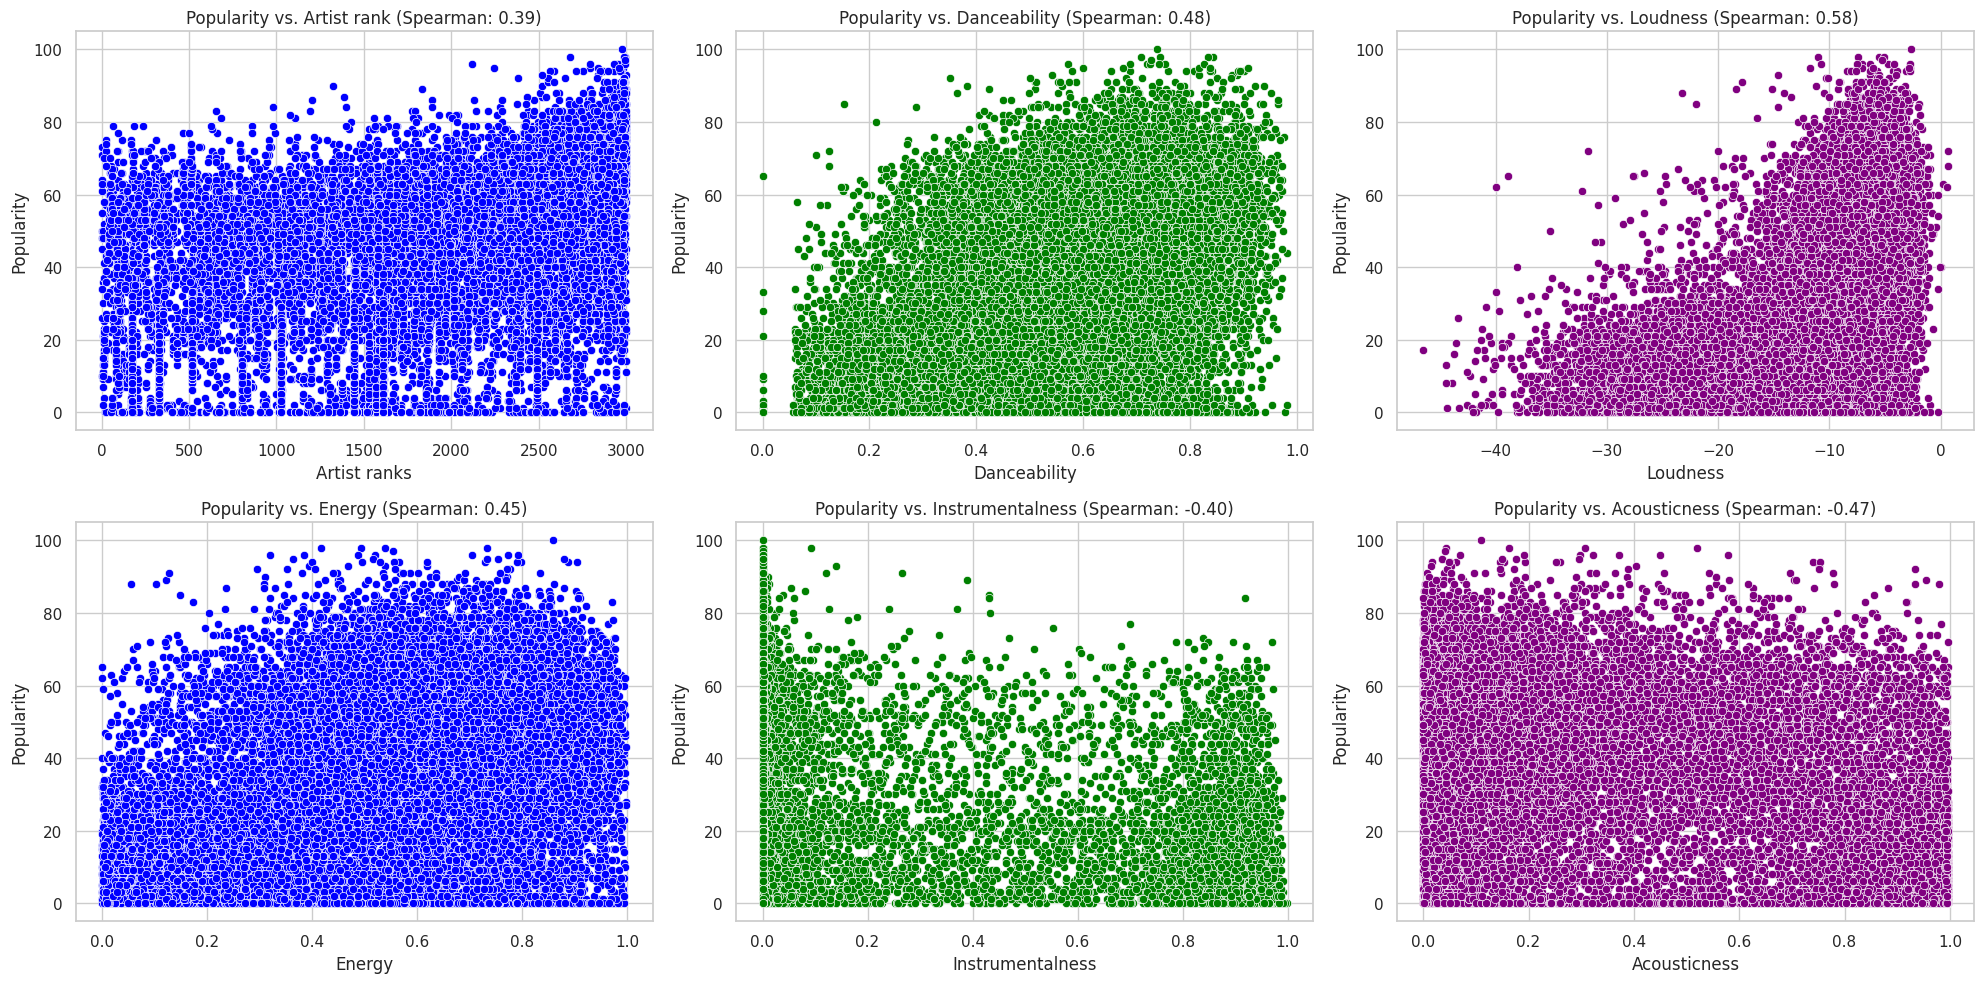

In [ ]:
sns.set(style="whitegrid")

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

corr_artist_rank, _ = spearmanr(train_df['artist_rank'], train_df['popularity'])
sns.scatterplot(x='artist_rank', y='popularity', data=train_df, ax=axs[0, 0], color='blue')
axs[0, 0].set_title(f'Popularity vs. Artist rank (Spearman: {corr_artist_rank:.2f})')
axs[0, 0].set_xlabel('Artist ranks')
axs[0, 0].set_ylabel('Popularity')

corr_danceability, _ = spearmanr(train_df['danceability'], train_df['popularity'])
sns.scatterplot(x='danceability', y='popularity', data=train_df, ax=axs[0, 1], color='green')
axs[0, 1].set_title(f'Popularity vs. Danceability (Spearman: {corr_danceability:.2f})')
axs[0, 1].set_xlabel('Danceability')
axs[0, 1].set_ylabel('Popularity')

corr_loudness, _ = spearmanr(train_df['loudness'], train_df['popularity'])
sns.scatterplot(x='loudness', y='popularity', data=train_df, ax=axs[0, 2], color='purple')
axs[0, 2].set_title(f'Popularity vs. Loudness (Spearman: {corr_loudness:.2f})')
axs[0, 2].set_xlabel('Loudness')
axs[0, 2].set_ylabel('Popularity')

corr_energy, _ = spearmanr(train_df['energy'], train_df['popularity'])
sns.scatterplot(x='energy', y='popularity', data=train_df, ax=axs[1, 0], color='blue')
axs[1, 0].set_title(f'Popularity vs. Energy (Spearman: {corr_energy:.2f})')
axs[1, 0].set_xlabel('Energy')
axs[1, 0].set_ylabel('Popularity')

corr_instrumentalness, _ = spearmanr(train_df['instrumentalness'], train_df['popularity'])
sns.scatterplot(x='instrumentalness', y='popularity', data=train_df, ax=axs[1, 1], color='green')
axs[1, 1].set_title(f'Popularity vs. Instrumentalness (Spearman: {corr_instrumentalness:.2f})')
axs[1, 1].set_xlabel('Instrumentalness')
axs[1, 1].set_ylabel('Popularity')

corr_acousticness, _ = spearmanr(train_df['acousticness'], train_df['popularity'])
sns.scatterplot(x='acousticness', y='popularity', data=train_df, ax=axs[1, 2], color='purple')
axs[1, 2].set_title(f'Popularity vs. Acousticness (Spearman: {corr_acousticness:.2f})')
axs[1, 2].set_xlabel('Acousticness')
axs[1, 2].set_ylabel('Popularity')

plt.tight_layout()
plt.show()


**1. Pozitívne korelácie**

- **Popularity vs. Artists** (ρ = 0.39)  
  Popularita mierne rastie pri lepšom rankingu interpretov. Najpopulárnejšie skladby patria často interpretom s najlepším umiestnením. Populárnejší umelci majú tendenciu vydávať skladby s vyššou popularitou, čo je očakávaný jav..

- **Popularity vs. Energy** (ρ = 0.45)  
  Popularita rastie s energiou skladby, no graf je roztrúsený. Menej výrazný vzťah.

- **Popularity vs. Danceability** (ρ = 0.48)  
  Skladby s vyššími hodnotami danceability majú vyššiu šancu stať sa populárnymi.

- **Popularity vs. Loudness** (ρ = 0.58)  
  Vidíme jasný pozitívny vzťah medzi hlasitosťou a popularitou. Skladby, ktoré sú hlasnejšie (hodnoty dB bližšie k 0), majú tendenciu byť populárnejšie


**2. Negatívne korelácie**

- **Popularity vs. Instrumentalness** (ρ = -0.40)  
  Väčšina populárnych skladieb má nízku inštrumentálnosť. Vidíme slabú negatívnu koreláciu – čím vyššia je inštrumentálnosť, tým nižšia je popularita skladieb.

- **Popularity vs. Acousticness** (ρ = -0.47)  
  Vysoká akustickosť je častejšie spojená s nižšou popularitou.


# 4. Predikčné modely  
Dáta sme spracovali štyrmi rôznymi metódami a následne ich porovnali na testovacom súbore.

### Regresné metódy
Cieľom bolo predikovať hodnotu popularity. Aby sme ich mohli porovnať s klasifikačnými metódami, považovali sme odhad za správny, ak bol v tolerancii ±5 od skutočnej hodnoty.

- **Lineárna regresia**
- **KNN regresia**

### Klasifikačné metódy  
Cieľom bolo predikovať popularitu skladby ako binárnu premennú – či je skladba populárna, podľa premennej popularity_bin. Ako bolo uvedené vyššie, skladbu považujeme za populárnu, ak patrí do top 25 % podľa hodnoty popularity.

- **Logistická regresia**
- **KNN klasifikácia**
- **Rozhodovací strom**



## Lineárna Regresia

Najskôr sa zameriavame na analýzu popularity pomocou lineárnej regresie. V tomto modeli pracujeme so stĺpcom popularity (nie s binárnym stĺpcom popularity bin), keďže lineárna regresia nie je vhodná na binárne klasifikácie – na tento účel sa používa logistická regresia (viď nižšie).

Našu implementáciu lineárnej regresie budeme postupne vylepšovať pomocou cross-validácie. Keďže presná predpoveď hodnoty popularity na úroveň percenta je veľmi náročná, zavádzame toleranciu ±5, ktorú považujeme za prijateľný odhad (tolerancia sa použije pri výpočte accuracy)

In [9]:
# @title Základna regresia - trénovanie

#prirpava trenovacej
y_train = train_df['popularity']
X_train = train_df.drop(columns=['popularity', 'track_id', 'track_name', 'artist_name', 'popularity_bin','duration_ms', 'key', 'tempo'])

# Normalizácia
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# trenovanie
model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_train_scaled)

mse = mean_squared_error(y_train, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")

# Zobrazenie koeficientov modelu
print("\nKoeficienty modelu:")
for feature, coef in zip(X_train.columns, model.coef_):
    print(f"{feature}: {coef:.4f}")

# Zobrazenie interceptu
print(f"Intercept: {model.intercept_:.4f}")


Mean Squared Error (MSE): 302.07

Koeficienty modelu:
acousticness: -1.8443
danceability: 5.1554
energy: -1.6276
instrumentalness: -0.9543
liveness: -2.3196
loudness: 9.7455
mode: -0.4880
speechiness: -0.4171
time_signature: 0.9300
valence: -3.9803
artist_rank: 4.2836
Intercept: 33.8130


V regresii som sa okrem klasických stĺpcov, ako sú popularita a popularita bin, rozhodla odstrániť aj stĺpce ako duration_ms, key a tempo. Na základe korelačnej matice sme zistili, že tieto premenné nemajú výrazný vplyv na model, a ich zahrnutie by ho mohlo zbytočne komplikovať.

Mean Squared Error (MSE): 298.29


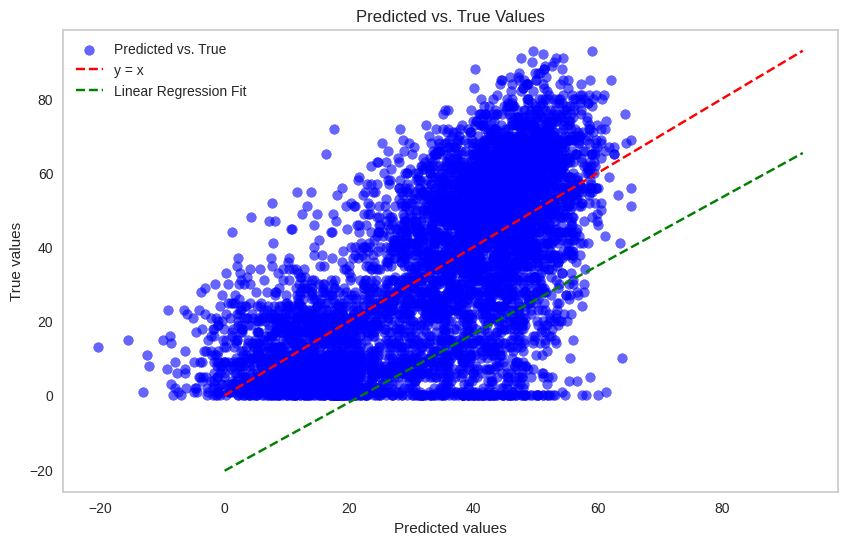

In [12]:
# @title Základná regresia - testovanie

y_test = test_df['popularity']
X_test = test_df.drop(columns=['popularity', 'track_id', 'track_name', 'artist_name', 'popularity_bin','duration_ms' , 'key', 'tempo'])

# Normalizácia
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, y_test, color='blue', alpha=0.6, label='Predicted vs. True')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='y = x')
plt.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], color='green', linestyle='--', label='Linear Regression Fit')


plt.title('Predicted vs. True Values')
plt.xlabel('Predicted values')
plt.ylabel('True values')

plt.legend()
plt.grid()
plt.show()



Chyba **MSE = 299,8** na testovacej sade je **pomerne vysoká, čo sme však očakávali**. Predpovedať popularitu hudby na základe parametrov, ktoré nevykazujú silnú koreláciu (čo potvrdzujú aj koeficienty modelu vo výstupe), je totiž veľmi náročné.

Pri pohľade na graf vidíme, že medzi hodnotami neexistuje priamočiary vzťah – hodnoty sa nenachádzajú presne na priamke \(y = x\), ale tvoria skôr zhluk. Aj preto sme sa rozhodli pokúsiť o vylepšenie tohto modelu.

Na vylepšenie sme použili **cross-validáciu**. Dáta rozdelíme do foldov, pričom ideálneoptimálny počet foldov hľadáme iteratívnym spôsobom.


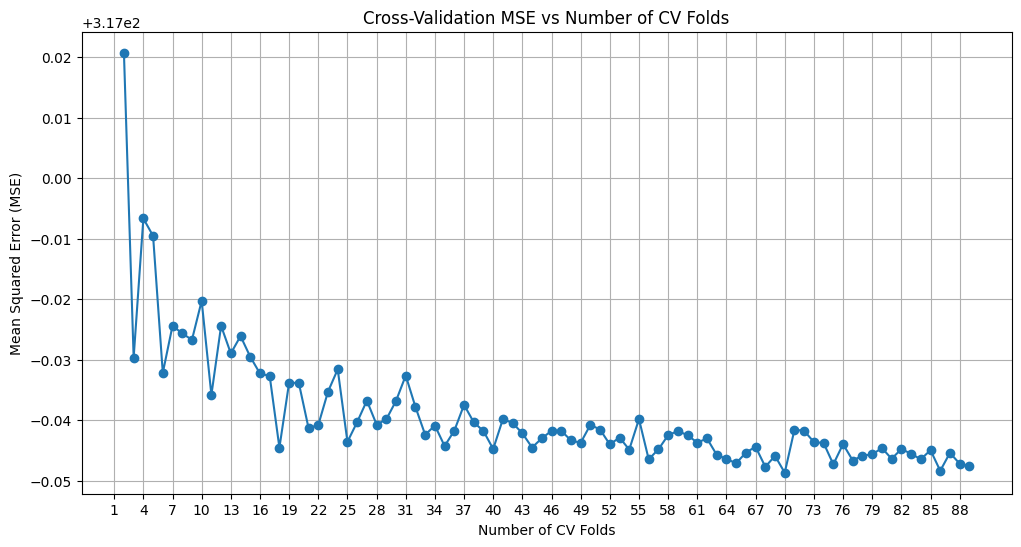

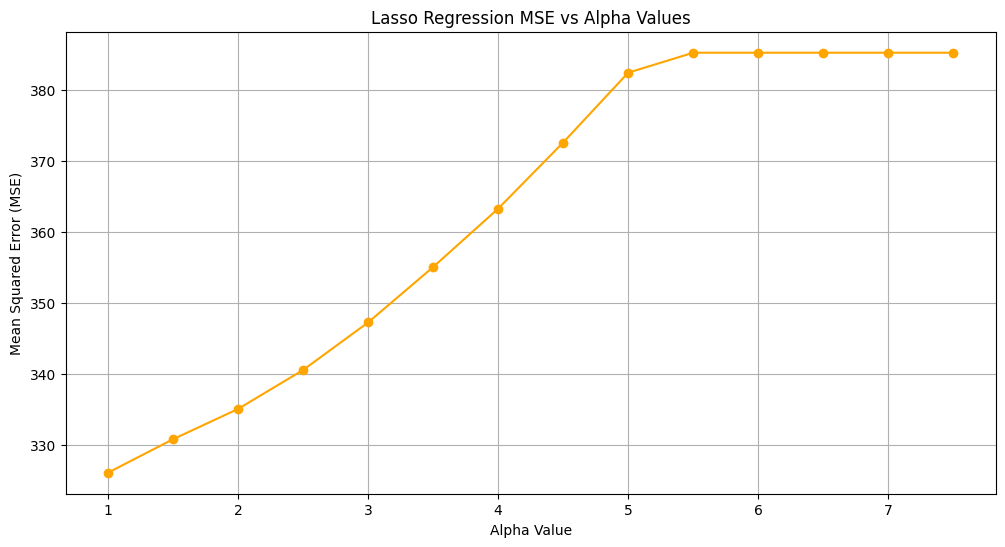

In [ ]:
# @title Crossvalidacia- Zisťovanie premenných
#inicializacia pipeline a naplnenie
pipeline = Pipeline([
    ('power_transform', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('scaler', StandardScaler())
])
X_poly = pipeline.fit_transform(X_train)

# ZISTOVANIE CV VALUE V CROSS VAL
cv_values = np.arange(2, 90, 1)
mse_values = []
for cv in cv_values:
    linear_model = LinearRegression()
    linear_mse = -cross_val_score(linear_model, X_poly, y_train, cv=cv, scoring='neg_mean_squared_error').mean()
    mse_values.append(linear_mse)

plt.figure(figsize=(12, 6))
plt.plot(cv_values, mse_values, marker='o')
plt.title('Cross-Validation MSE vs Number of CV Folds')
plt.xlabel('Number of CV Folds')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(range(1, max(cv_values) + 1, 3))
plt.grid()
plt.show()

# ZISTOVANIE ALPHA VALUE V
alpha_values = np.arange(1, 8, 0.5)
lasso_mse_values = []
for alpha in alpha_values:
    lasso_model = Lasso(alpha=alpha)
    lasso_mse = -cross_val_score(lasso_model, X_poly, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    lasso_mse_values.append(lasso_mse)

plt.figure(figsize=(12, 6))
plt.plot(alpha_values, lasso_mse_values, marker='o', color='orange')
plt.title('Lasso Regression MSE vs Alpha Values')
plt.xlabel('Alpha Value')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid()
plt.show()


In [ ]:
#ZISTOVANIE STUPNA POLY TRANSFORMACIE
degree_values = np.arange(1, 4)
for degree in degree_values:
    pipeline = Pipeline([
        ('power_transform', PowerTransformer(method='yeo-johnson', standardize=False)),
        ('scaler', StandardScaler()),
        ('poly_features', PolynomialFeatures(degree=degree, include_bias=False)),
        ('linear_model', LinearRegression())
    ])

    linear_mse = -cross_val_score(pipeline, X_train, y_train, cv=35, scoring='neg_mean_squared_error').mean()
    print(f"Polynomial Degree: {degree}, MSE: {linear_mse:.4f}")


Polynomial Degree: 1, MSE: 300.6173
Polynomial Degree: 2, MSE: 267.1495
Polynomial Degree: 3, MSE: 260.5277


Rozhodli sme sa použiť pipeline, pretože je prehľadná a umožňuje jednoduché zapojenie viacerých transformácií postupne. Môžem upraviť kombináciu transformácií priamo v rámci jednej štruktúry, čo zjednodušuje následné testovanie. Počas validácie a testovania môžem aplikovať rovnaké kroky bez potreby znovu definovať jednotlivé transformácie.

Pre PowerTransformer sme sa rozhodli, pretože dokáže pracovať aj s negatívnymi hodnotami (viac o nej v dokumentacii: https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer.get_params )

Taktiež sme  použili StandardScaler na skálovanie dát.

**Kroky:**

1. V programe sme najskôr optimalizovali počet foldov v rámci cross validácie. Najlepšie výsledky vidime ze su okolo 40 foldov kede sa  MSE uz stabilizuje.
2.  Pri optimalizácii parametra alpha pre Lasso regresiu, ktorý slúži na zníženie rizika overfittingu, sme zistili, že najlepšie výsledky dosahuje najmenšia hodnota alpha. To naznačuje, že regularizácia v tomto prípade neprináša výrazný prínos, a preto sme sa rozhodli Lasso regresiu vôbec nepoužiť. Všetky nepotrebné stĺpce sme už predtým odstránili.
3. Pri skúmaní poly transformácie sa ukázalo, že vzhľadom na to, že dáta podľa grafu 1 nie sú lineárne, bude najvhodnejšie použiť poly transformáciu až do tretieho stupňa.

Všetky tieto optimalizácie sme implementovali a aplikovali na testovacom súbore.

In [ ]:
# @title Zlepsena linearna regresia
pipeline = Pipeline([
    ('power_transform', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=3, include_bias=False))
])

X_poly = pipeline.fit_transform(X_train)

crossval_model = LinearRegression()
crossval_model.fit(X_poly, y_train)
lasso_mse = -cross_val_score(crossval_model, X_poly, y_train, cv=35, scoring='neg_mean_squared_error').mean()

print(f"MSE for Cross-Validation Model (cv=35): {lasso_mse:.4f}")


MSE for Cross-Validation Model (cv=35): 260.2752


In [ ]:
# @title Testovanie Zlepsenej Linearnej regresie

X_test_poly = pipeline.transform(X_test)
y_pred = crossval_model.predict(X_test_poly)


mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE) na testovacej sade: {mse:.2f}")



Mean Squared Error (MSE) na testovacej sade: 256.17


Podarilo sa nám zlepšiť hodnotu MSE na testovacej sade z pôvodných 298.8 na 256.1, čo predstavuje zlepšenie o takmer 15 %. Toto zlepšenie hodnotíme pozitívne. Avšak predpoveď je stále ďaleko od použiteľnej predpovede. Aj keď nám nepriniesla vysokú presnosť, aspoň nám ukázala zaujímavé poznatky a vzťahy medzi premennými a tiež nám ukázala, že toto nie je správny model na takéto dáta.

Ukázalo sa, že je veľmi náročné presne predpovedať popularitu skladby len na základe dostupných atribútov.  Aspon sa nam potvrdili naše počiatočné štatistiky a vidime ze sa nimi riadi aj model.

Pozitívny vplyv na popularitu:


* danceability

Negatívny vplyv na popularitu:

* acousticness

* energy

* instrumentalness

* speechiness


In [ ]:
# @title Accuracy
tolerance = 5
correct_predictions = np.abs(y_pred - y_test) <= tolerance
incorrect_predictions = np.abs(y_pred - y_test) > tolerance

accuracy = (np.sum(correct_predictions) / len(y_test)) *100
print(accuracy, '%')

25.76404302543964 %


**Porovnanie modelov pomocou accuracy**

Pre porovnanie nášho modelu s inými prístupmi sme sa rozhodli použiť accuracy. Avšak lineárna regresia je v tomto prípade v nevýhode, pretože ako jediný model neberie do úvahy binárnu premennú 'popularity_bin', ale skutočnú hodnotu popularity, čo si vyžaduje veľmi presné predpovede.

**Tolerancia pri hodnotení predikcií**

Aby sme tento problém obmedzili, zaviedli sme toleranciu pri hodnotení správnosti predikcií. Konkrétne, ak sa predikcia líši od skutočnej hodnoty o ±5, považujeme ju za správnu. Týmto spôsobom sme umožnili modelu byť menej prísnym pri hodnotení presnosti predikcií.

**Výsledky s toleranciou**

Dosiahnuté 25,7% presnosti pri predikcii popularity s toleranciou nie je uspokojivý výsledok. Rozhodli sme sa preto prístup zmeniť a zamerať sa na klasifikáciu skladieb do dvoch skupín: populárne a nepopulárne. Na tento účel sme využili nasledujúce modely:

## Logistická Regresia

Naším cieľom je vytvoriť model, ktorý dokáže spoľahlivo rozlíšiť populárne a menej populárne piesne. Definujeme populárnu pieseň ako takú, ktorej kvantil je väčší alebo rovný 75. Túto informáciu reprezentujeme binárnou premennou "popularity_bin", kde hodnota 1 označuje populárnu pieseň a 0 nepopulárnu.

Na základe širokého spektra hudobných atribútov, ako je tanečnosť, energia, akustickosť a ďalších, sme zvolili logistickú regresiu ako vhodný nástroj pre túto binárnu klasifikáciu. Logistická regresia nám umožňuje odhadnúť pravdepodobnosť, s akou patrí daná pieseň do kategórie populárnych.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

features = ['danceability', 'energy', 'key', 'acousticness', 'liveness', 'loudness', 'mode',
            'speechiness', 'tempo', 'time_signature', 'instrumentalness', 'valence', 'duration_ms', 'artist_rank']

X = df[features]
y = df['popularity_bin']

# Rozdelenie dát na trénovaciu a validačnú množinu
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Použitie SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Pôvodné rozloženie tréningových dát:")
print(y_train.value_counts())
print("Rozloženie tréningových dát po SMOTE:")
print(y_train_resampled.value_counts())

# Tréning
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)


y_pred = model.predict(X_valid)
y_prob = model.predict_proba(X_valid)[:, 1]

# Vyhodnotenie
roc_auc = roc_auc_score(y_valid, y_prob)
print(f"ROC-AUC Score: {roc_auc}")

accuracy = accuracy_score(y_valid, y_pred)
print(f"Accuracy: {accuracy}")

print("Classification Report:\n", classification_report(y_valid, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred))




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Pôvodné rozloženie tréningových dát:
popularity_bin
0    17252
1     6172
Name: count, dtype: int64
Rozloženie tréningových dát po SMOTE:
popularity_bin
0    17252
1    17252
Name: count, dtype: int64
ROC-AUC Score: 0.805341369060955
Accuracy: 0.7199931705651358
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.70      0.79      4300
           1       0.48      0.77      0.59      1557

    accuracy                           0.72      5857
   macro avg       0.69      0.74      0.69      5857
weighted avg       0.78      0.72      0.74      5857

Confusion Matrix:
 [[3017 1283]
 [ 357 1200]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Úprava dát
Pôvodné dáta boli značne nevyvážené, čo mohlo viesť k zaujatosti modelu v prospech dominantnej triedy. Preto sme použili techniku <strong>SMOTE (Synthetic Minority Oversampling Technique)</strong>, ktorá synteticky generuje nové príklady pre menšinovú triedu na základe existujúcich dát. Týmto spôsobom sme dosiahli rovnomerné zastúpenie oboch tried v našom dátovom súbore.

### Testovanie

In [ ]:
test_df['popularity_bin'] = np.where(test_df['popularity'] >= 50, 1, 0)

test_y = test_df['popularity_bin']

test_X = test_df[features]
test_y_pred = model.predict(test_X)
test_y_prob = model.predict_proba(test_X)[:, 1]

test_roc_auc = roc_auc_score(test_y, test_y_prob)
test_accuracy = accuracy_score(test_y, test_y_pred)

print(f"Test ROC-AUC Score: {test_roc_auc}")
print(f"Test Accuracy: {test_accuracy}")
print("Test Classification Report:\n", classification_report(test_y, test_y_pred))

Test ROC-AUC Score: 0.8080510620549946
Test Accuracy: 0.7302373228615332
Test Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.72      0.79      4020
           1       0.55      0.75      0.63      1837

    accuracy                           0.73      5857
   macro avg       0.71      0.73      0.71      5857
weighted avg       0.76      0.73      0.74      5857



### Výsledky modelu
Accuracy: 73% – Celková presnosť modelu, t.j. percento správne klasifikovaných prípadov.

Precision: 55% – Model správne klasifikuje ako populárne len 55% skutočne populárnych piesní.

Recall: 75% – Model dokáže identifikovať 75% všetkých skutočne populárnych piesní.

F1-score: 63% – Harmonický priemer precision a recall, ktorý poskytuje vyvážený ukazovateľ výkonnosti.

Model dosahuje prijateľnú celkovú presnosť (73.02%), avšak pri podrobnejšom pohľade na jednotlivé triedy vidíme rozdiely vo výkonnosti.

Trieda 0 (Nepopulárne piesne):

Model má vysokú presnosť pri klasifikácii nepopulárnych piesní. To znamená, že väčšinu piesní, ktoré označí ako nepopulárne, skutočne nepopulárne sú. Recall (72%) naznačuje, že model dokáže identifikovať väčšinu všetkých nepopulárnych piesní v dátach.

Trieda 1 (Populárne piesne):

Precision pre populárne piesne je 55%, čo znamená, že viac ako polovica piesní označených ako populárne je skutočne populárna.  Recall (75%) ukazuje, že model dokáže identifikovať väčšinu populárnych piesní. Tieto hodnoty naznačujú, že náš model má menšie problémy s identifikáciou populárnych piesní.

### Confusion Matrix

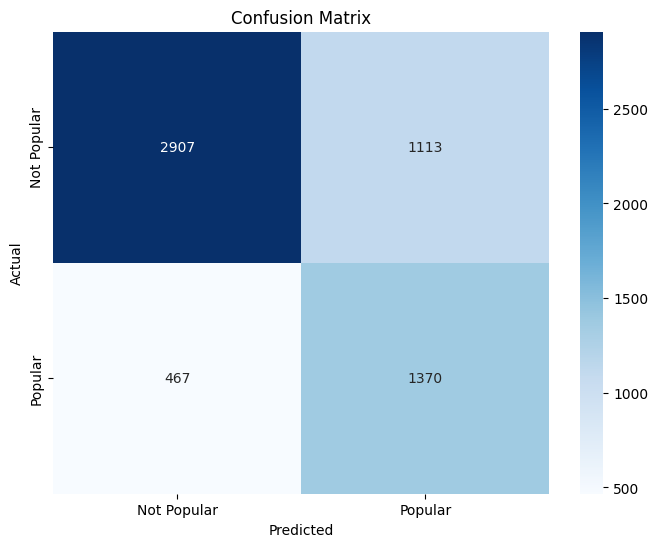

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_y, test_y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Popular', 'Popular'], yticklabels=['Not Popular', 'Popular'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

True Negatives (Not Popular správne predikované): 2907

False Positives (chybne predikované Popular): 1113

False Negatives (Popular chybne predikované Not Popular): 467

True Positives (Popular správne predikované): 1370


### ROC AUC krivka

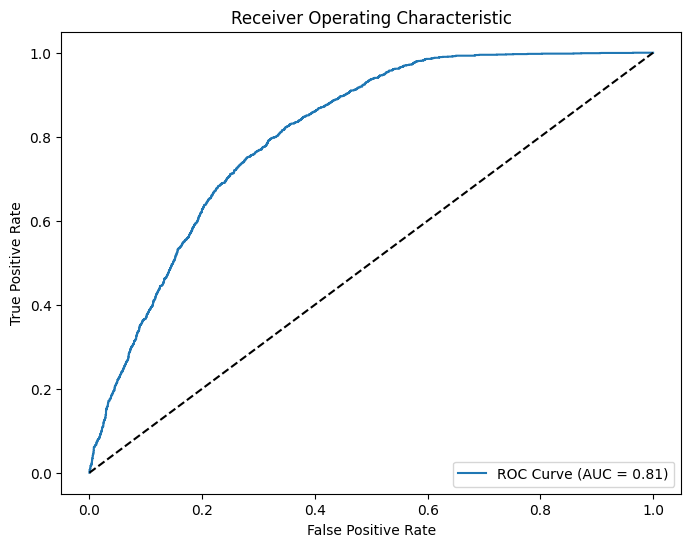

In [ ]:
fpr, tpr, thresholds = roc_curve(test_y, test_y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


ROC krivka zobrazuje vzťah medzi True Positive Rate (Recall) a False Positive Rate pre rôzne prahové hodnoty klasifikácie. Meria schopnosť modelu rozlišovať medzi triedami.

V našom prípade: AUC = 0.81, čo naznačuje veľmi dobrú výkonnosť modelu pri rozlišovaní medzi populárnymi a nepopulárnymi skladbami.

### Precision-Recall krivka

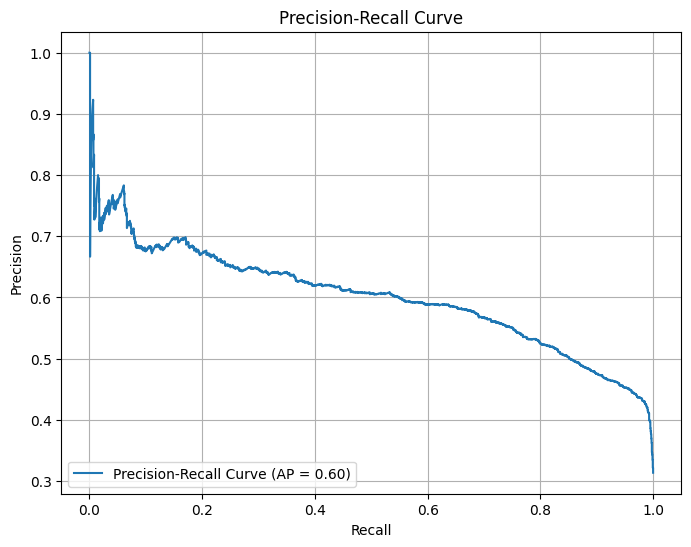

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(test_y, test_y_prob)
avg_precision = average_precision_score(test_y, test_y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

Táto krivka graficky znázorňuje vzťah medzi precision (podiel správne klasifikovaných pozitívnych prípadov zo všetkých označených ako pozitívne) a recall (podiel správne klasifikovaných pozitívnych prípadov zo všetkých skutočne pozitívnych prípadov) modelu pri rôznych prahových hodnotách.

<strong> Pozorovanie:</strong>

Na začiatku krivky, kde je úplnosť (recall) nízka, dosahuje model veľmi vysokú presnosť. To znamená, že model je v tomto režime veľmi opatrný a klasifikuje ako populárne len tie piesne, o ktorých je si veľmi istý. Takéto prípady sú zväčša správne klasifikované (true positives).

S rastúcou úplnosťou postupne klesá presnosť. Pri snahe zvýšiť počet správne identifikovaných populárnych piesní (zvýšiť recall) model nevyhnutne zaradí medzi ne aj niektoré nesprávne prípady (false positives), čo vedie k zníženiu presnosti.

Priemerná presnosť (AP) má hodnotu 0,60, čo indikuje uspokojivý, ale nie vynikajúci výkon. To znamená, že model dokáže dosiahnuť dobrú rovnováhu medzi presnosťou a úplnosťou, ale existuje priestor na zlepšenie, najmä pri vyšších hodnotách úplnosti.

Stabilný pokles presnosti v strednej oblasti krivky naznačuje, že model dosahuje svoje limity pri klasifikácii menej zrejmých prípadov. To znamená, že existuje určitá hranica, po ktorej sa model začína viac mýliť.

Krivka ukazuje, že náš model je schopný spoľahlivo identifikovať najzreteľnejšie prípady populárnych piesní, ale má ťažkosti s menej zrejmými prípadmi.

### Záver




Získané výsledky modelu logistickej regresie, s ROC-AUC 0.81 a presnosťou 73.02%, naznačujú uspokojivý výkon, najmä pri klasifikácii nepopulárnych piesní. Výrazne lepší recall pre populárne piesne poukazuje na schopnosť modelu identifikovať väčšinu relevantných prípadov, hoci presnosť (precision) je nižšia. Napriek tomu, model má určité obmedzenia pri identifikácii populárnych piesní. Táto skutočnosť môže byť spôsobená viacerými faktormi, ako je napríklad zložitosť popularity hudby alebo nedostatok relevantných dát.

 Naším ďalším cieľom je preskúmať iné modely a techniky, ktoré by mohli lepšie zachytiť komplexnosť tohto problému.

##  KNN

###  KNN Regresia
V tejto časti sme použili regresný model K-Nearest Neighbors (KNN) na predikciu popularity skladieb. Začali sme tým, že sme z datasetu odstránili nepotrebné stĺpce, ako sú názvy interpretov, ID skladieb a binarizovanú popularitu.

Pre lepšie výsledky predikcie sme využili nasledujúce metódy:


*   StandardScaler - Škálovanie číselných premenných, aby sme zabezpečili rovnakú váhu všetkých vstupných premenných. Obzvlášť dôležité pri KNN, kde vzdialenosti medzi bodmi zohrávajú kľúčovú úlohu.
*   PCA - Redukcia rozmerov dát, aby sme udržali 95 % pôvodného rozptylu dát, Tento krok pomohol znížiť počet vstupných premenných a zároveň zlepšil výpočtovú efektivitu modelu bez výraznej straty informácií.
*   GridSearchCV - Optimalizácia hyperparametrov modelu s 5-násobnou krížovou validáciou. Hľadali sme najlepšie hodnoty pre počet susedov a váhovú funkciu.

In [ ]:
# Drop columns
train_df_knn = train_df.drop(columns=['artist_name', 'track_id', 'track_name', 'popularity_bin'])
test_df_knn = test_df.drop(columns=['artist_name', 'track_id', 'track_name', 'popularity_bin'])

X_train = train_df_knn.drop('popularity', axis=1)
y_train = train_df_knn['popularity']
X_test = test_df_knn.drop('popularity', axis=1)
y_test = test_df_knn['popularity']

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA
pca = PCA(n_components=0.95)
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

# GridSearchCV
param_grid = {'n_neighbors': [5,10,20,30,40,50,60,70], 'weights': ['uniform', 'distance']}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

best_knn_regressor = grid_search.best_estimator_
y_pred = best_knn_regressor.predict(X_test_scaled)


In [ ]:
# Testovacia sada
best_params = grid_search.best_params_
mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
# Tolerancce =+-5
tolerance = 5
errors_test = np.abs(y_pred - y_test)
accurate_predictions_test = np.sum(errors_test <= tolerance)
accuracy_test = accurate_predictions_test / len(y_test) * 100

print(f"Best Parameters: {best_params}")
print(f"Mean Squared Error on Test Set: {mse_test:.2f}")
print(f"R-squared on Test Set: {r2_test:.2f}")
print(f"Accuracy within ±{tolerance} on Test Set: {accuracy_test:.2f}%")

# Príklady predikcií na testovacej sade
predictions_test = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Error': errors_test})
print(predictions_test.head())

# Trénovacia sada
y_pred_train = best_knn_regressor.predict(X_train_scaled)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
errors_train = np.abs(y_pred_train - y_train)
accurate_predictions_train = np.sum(errors_train <= tolerance)
accuracy_train = accurate_predictions_train / len(y_train) * 100

print()
print(f"Mean Squared Error on Training Set: {mse_train:.2f}")
print(f"R-squared on Training Set: {r2_train:.2f}")
print(f"Accuracy within ±{tolerance} on Training Set: {accuracy_train:.2f}%")

# Príklady predikcií na tréningovej sade
predictions_train = pd.DataFrame({'Actual': y_train, 'Predicted': y_pred_train, 'Error': errors_train})
print(predictions_train.head())


Best Parameters: {'n_neighbors': 30, 'weights': 'distance'}
Mean Squared Error on Test Set: 261.81
R-squared on Test Set: 0.50
Accuracy within ±5 on Test Set: 25.95%
       Actual  Predicted      Error
24829      50  57.048560   7.048560
18538      22  31.062701   9.062701
5699       56  42.620444  13.379556
28947      52  40.155189  11.844811
12650      73  54.649579  18.350421

Mean Squared Error on Training Set: 1.05
R-squared on Training Set: 1.00
Accuracy within ±5 on Training Set: 99.60%
       Actual  Predicted  Error
70         47       47.0    0.0
5509       15       15.0    0.0
16120       2        2.0    0.0
15057       3        3.0    0.0
1880       48       48.0    0.0


KNN regresný model dosiahol najlepší výsledok pri hodnote n_neighbors = 30. Konkrétne dosiahol MSE = 261,81 a R² = 0,50, čo znamená, že model dokáže vysvetliť 50 % variability v dátach. Iba 25,95 % predikcií sa nachádzalo v tolerancii ±5 od skutočných hodnôt, čo naznačuje, že model má priestor na zlepšenie presnosti predikcií. V porovnaní s lineárnou regresiou dosiahol KNN veľmi podobné výsledky.

Pri porovnaní výkonu na tréningovej a testovacej sade vidíme, že model KNN má problém s pretrénovaním, čo je evidentné z výrazného rozdielu medzi výkonom na tréningovej a testovacej sade. Na tréningových dátach model dosahuje vynikajúce výsledky s veľmi nízkym MSE a vysokou presnosťou, zatiaľ čo na testovacej sade je výkon slabší. To naznačuje, že model sa príliš prispôsobil špecifikám tréningových dát a nedokáže sa dobre generalizovať. Zníženie počtu susedov nepomohlo, ba naopak, chyba na testovacích dátach sa ešte zvýšila.

Na zlepšenie výkonu modelu by bolo vhodné pridanie nových premenných, ktoré by mali silnejšiu koreláciu s hodnotami popularity, alebo vyskúšanie iných modelov, ako sú Random Forest alebo Gradient Boosting, ktoré by lepšie zvládali variabilitu dát a tým by pomohli predísť pretrénovaniu.


###  KNN Klasifikácia
V druhom prístupe vyhodnocovania popularity pomocou KNN, sme zvolili klasifikačný model. Tento model predikuje popularitu skladieb ako binárnu hodnotu, kde skladba buď patrí do top 25% (populárne) alebo nie (nepopulárne).

Postup bol podobný ako pri regresnom modeli, no hlavná zmena spočíva v spôsobe vyhodnocovania modelu. Pri regresnom modeli sme používali MSE, zatiaľ čo pri klasifikácii sme vyhodnocovali model pomocou accuracy, recall či precision.

V tomto prístupe sme tiež použili StandardScaler na škálovanie dát a GridSearchCV na optimalizáciu hyperparametrov. Parametre sme optimalizovali dvomi spôsobmi: raz pre accuracy a raz pre recall.



In [ ]:
# Drop categoric columns
train_df_knn = train_df.drop(columns=['artist_name', 'track_id', 'track_name', 'popularity'])
test_df_knn = test_df.drop(columns=['artist_name', 'track_id', 'track_name', 'popularity'])

X_train = train_df_knn.drop('popularity_bin', axis=1)
y_train = train_df_knn['popularity_bin']

X_test = test_df_knn.drop('popularity_bin', axis=1)
y_test = test_df_knn['popularity_bin']

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# GridSearchCV without class_weight (since KNeighborsClassifier doesn't support it)
param_grid = {'n_neighbors': [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]}

#scoring = accuracy
grid_search_acc = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search_acc.fit(X_train_scaled, y_train)
best_knn_classifier_acc = grid_search_acc.best_estimator_
best_knn_classifier_acc.fit(X_train_scaled, y_train)

#scoring = recall
grid_search_r = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='recall')
grid_search_r.fit(X_train_scaled, y_train)
best_knn_classifier_r = grid_search_r.best_estimator_
best_knn_classifier_r.fit(X_train_scaled, y_train)

# Predictions on the test data
y_pred_acc = best_knn_classifier_acc.predict(X_test_scaled)
y_pred_r = best_knn_classifier_r.predict(X_test_scaled)


In [ ]:
from sklearn.metrics import f1_score

# Pre Accuracy model
print("Accuracy")
print("Best Hyperparameters from Grid Search:", grid_search_acc.best_params_)

accuracy = accuracy_score(y_test, y_pred_acc)
precision = precision_score(y_test, y_pred_acc)
recall = recall_score(y_test, y_pred_acc)
f1 = f1_score(y_test, y_pred_acc)  # F1 Score
conf_matrix = confusion_matrix(y_test, y_pred_acc)
roc_auc = roc_auc_score(y_test, best_knn_classifier_acc.predict_proba(X_test_scaled)[:, 1])

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")  # F1 Score
print(f"ROC AUC Score: {roc_auc:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print()

# Pre Recall model
print("Recall")
print("Best Hyperparameters from Grid Search:", grid_search_r.best_params_)

accuracy = accuracy_score(y_test, y_pred_r)
precision = precision_score(y_test, y_pred_r)
recall = recall_score(y_test, y_pred_r)
f1 = f1_score(y_test, y_pred_r)  # F1 Score
conf_matrix = confusion_matrix(y_test, y_pred_r)
roc_auc = roc_auc_score(y_test, best_knn_classifier_r.predict_proba(X_test_scaled)[:, 1])

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")  # F1 Score
print(f"ROC AUC Score: {roc_auc:.2f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy
Best Hyperparameters from Grid Search: {'n_neighbors': 60}
Accuracy: 78.62%
Precision: 62.61%
Recall: 48.62%
F1 Score: 54.74%
ROC AUC Score: 0.83
Confusion Matrix:
[[3848  452]
 [ 800  757]]

Recall
Best Hyperparameters from Grid Search: {'n_neighbors': 5}
Accuracy: 76.20%
Precision: 55.88%
Recall: 49.71%
F1 Score: 52.62%
ROC AUC Score: 0.79
Confusion Matrix:
[[3689  611]
 [ 783  774]]


Accuracy Model (n_neighbors = 60): Model optimalizovaný na metriky presnosti dosiahol výborné výsledky, s presnosťou 78.62% a ROC AUC skóre 0.83. To naznačuje, že model sa celkovo dobre vyrovnáva s rozlišovaním medzi populárnymi a nepopulárnymi skladbami. Vyššie ROC AUC skóre znamená, že model je veľmi efektívny pri rozlišovaní medzi triedami, aj keď nie všetky populárne skladby sú správne identifikované.

Recall Model (n_neighbors = 5): Model zameraný na recall dosiahol F1 skóre 52.62%, čo je len o niečo nižšie v porovnaní s modelom optimalizovaným na presnosť. Recall je 49.71%, čo naznačuje, že aj keď sa model zameral na zachytávanie populárnych skladieb, stále neidentifikuje dostatočné množstvo z nich. Model teda nevykazuje výrazné zlepšenie v porovnaní s modelom orientovaným na presnosť.

Zhodnotenie: Oba modely dosiahli relatívne dobré výsledky v accuracy, ale obmedzenia v recalla precision znamenajú, že modely nedokážu zachytiť všetky populárne skladby. Tým obmedzujú použiteľnosť modelu. Zlepšenie týchto metrik môže byť kľúčové, ak je našou prioritou identifikácia čo najväčšieho počtu populárnych skladieb.


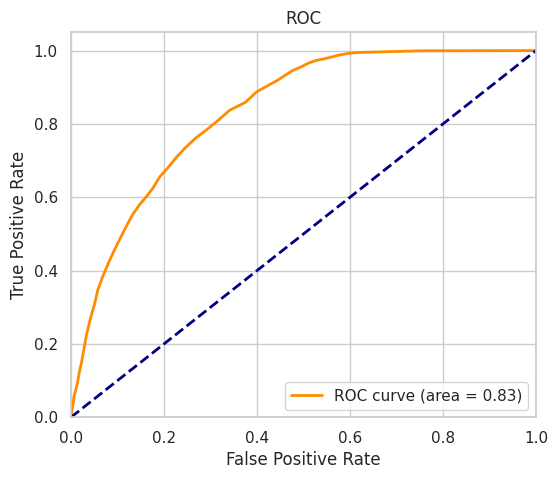

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, best_knn_classifier_acc.predict_proba(X_test_scaled)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

Hodnota AUC nám vyšla 0,83. Znamená to, že pravdepodobnosť, že model správne klasifikuje pozitívny príklad ako pozitívny a negatívny ako negatívny je 83 %.
Model má dobrú schopnosť rozlišovať medzi pozitívnou a negatívnou triedou, čo naznačuje, že jeho výkon je oveľa lepší ako náhoda, ale stále existuje priestor na zlepšenie.

## Rozhodovaci Strom

In [ ]:
train_X = train_df.drop(['popularity_bin', "track_id", "track_name", "artist_name", 'popularity'], axis=1)
train_y = train_df['popularity_bin']

test_X = test_df.drop(['popularity_bin', "track_id",  "track_name", "artist_name", 'popularity'], axis=1)
test_y = test_df['popularity_bin']

In [ ]:
# @title Klasifikačný rozhodovací strom
tree_model = DecisionTreeClassifier(random_state=42, max_depth=10, class_weight='balanced')

# Trénujeme na trénovacích dátach
tree_model.fit(train_X, train_y)


DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=42)

In [ ]:
# @title Kvalita modelu - Accuracy, Confusion Matrix
train_predictions = tree_model.predict(train_X)
test_predictions = tree_model.predict(test_X)

train_accuracy = accuracy_score(train_y, train_predictions)
print("Training Accuracy:", train_accuracy)
print("Confusion Matrix:\n", confusion_matrix(train_y, train_predictions))
print("Classification Report:\n", classification_report(train_y, train_predictions))

accuracy = accuracy_score(test_y, test_predictions)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_matrix(test_y, test_predictions))
print("Classification Report:\n", classification_report(test_y, test_predictions))



Training Accuracy: 0.7459443306010929
Confusion Matrix:
 [[11572  5680]
 [  271  5901]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.67      0.80     17252
           1       0.51      0.96      0.66      6172

    accuracy                           0.75     23424
   macro avg       0.74      0.81      0.73     23424
weighted avg       0.85      0.75      0.76     23424

Accuracy: 0.6964316202834215
Confusion Matrix:
 [[2721 1579]
 [ 199 1358]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.63      0.75      4300
           1       0.46      0.87      0.60      1557

    accuracy                           0.70      5857
   macro avg       0.70      0.75      0.68      5857
weighted avg       0.81      0.70      0.71      5857



**Trénovacie dáta**

Tréningová presnosť je 74,50 %, čo znamená, že model správne klasifikoval takmer 75 % prípadov na trénovacích dátach. Toto číslo nás ale v skutočnosti až tak nezaujíma, keďže naším hlavným cieľom je správne klasifikovať populárne pesničky.

* Recall (citlivosť) pre triedu 1: 96 % - náš model dokáže zachytiť takmer všetky populárne skladby, čo je zásadné pre náš cieľ.
* Precision (presnosť) pre triedu 1: 51 % - model má pri predikcii triedy 1 viac falošne pozitívnych prípadov, teda nepopulárne skladby označí ako populárne.
* F1-score pre triedu 1: 0.66 - ukazuje, že model má slušný balans medzi presnosťou a citlivosťou pri predikcii populárnych skladieb.
* Presnosť modelu: 74.6 % - celkový výkon modelu na dátach je slušný, no nie perfektný.

**Testovacie dáta**

* Recall (citlivosť) pre triedu 1: 87 % - aj na nových dátach model zachytí väčšinu populárnych skladieb.
* Precision (presnosť) pre triedu 1: 46 % presnosť je nižšia ako na trénovacích dátach, čo znamená, že model má stále viac falošne pozitívnych prípadov.
* F1-score pre triedu 1: 0.60 - model má kompromis medzi presnosťou a citlivosťou.
* Celková presnosť: 69.6 % - výkon modelu na testovacích dátach je primeraný, hoci hlavný dôraz je na triedu 1.

**Záver:**

* Vysoký recall pre triedu 1 (96 % na tréningových a 87 % na testovacích dátach) naznačuje, že model spoľahlivo zachytáva väčšinu populárnych skladieb, čo je kľúčové pre náš cieľ.
* F1-score pre triedu 1 (0.66 na tréningových a 0.60 na testovacích dátach) ukazuje dobrý balans medzi citlivosťou a presnosťou, pričom model si udržiava primeraný výkon aj na nových dátach.
* Stabilná presnosť medzi tréningovými (74.6 %) a testovacími (69.6 %) dátami naznačuje, že model nie je výrazne pretrénovaný a dokáže generalizovať.
Relatívne nízka presnosť pre triedu 1 (51 % na tréningových a 46 % na testovacích dátach) signalizuje, že model často označuje nepopulárne skladby ako populárne, čo by mohlo byť zlepšené ďalším ladením.

Training AUC: 0.893
Test AUC: 0.808


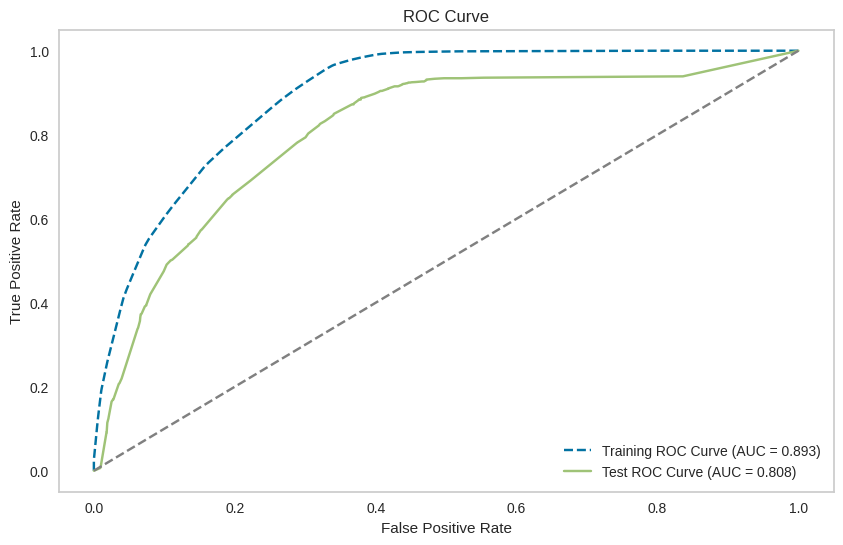

In [ ]:
# @title Kvalita modelu - AUC-ROC krivka
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, RocCurveDisplay
)
train_probs = tree_model.predict_proba(train_X)[:, 1]
test_probs = tree_model.predict_proba(test_X)[:, 1]

train_fpr, train_tpr, _ = roc_curve(train_y, train_probs)
test_fpr, test_tpr, _ = roc_curve(test_y, test_probs)

train_auc = auc(train_fpr, train_tpr)
test_auc = auc(test_fpr, test_tpr)

print(f"Training AUC: {train_auc:.3f}")
print(f"Test AUC: {test_auc:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(train_fpr, train_tpr, label=f'Training ROC Curve (AUC = {train_auc:.3f})', linestyle='--')
plt.plot(test_fpr, test_tpr, label=f'Test ROC Curve (AUC = {test_auc:.3f})', linestyle='-')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonála náhodného modelu
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

**AUC skóre pre tréningovú množinu (0.893):**

* Model má veľmi dobrú schopnosť odlišovať medzi triedami na tréningových dátach. AUC hodnota 0.893 naznačuje, že model efektívne zachytáva rozdiely medzi populárnymi a nepopulárnymi skladbami počas tréningu.
* Blízkosť k hodnote 1 znamená, že model má nízke množstvo falošne pozitívnych a falošne negatívnych predikcií.

**AUC skóre pre testovaciu množinu (0.808):**
* Výkon modelu na testovacích dátach je stále dobrý, ale mierne slabší ako na tréningových dátach. Tento rozdiel (0.085) naznačuje, že model nie je výrazne pretrénovaný a dokáže generalizovať na nové dáta.
* AUC hodnota nad 0.8 indikuje, že model je schopný správne odlišovať triedy v drvivej väčšine prípadov, aj na nových dátach.

**Tvar ROC kriviek:**

Tréningová krivka je bližšie k hornému ľavému rohu, čo značí vyššiu citlivosť pri zachovaní nízkeho množstva falošne pozitívnych predikcií.
Testovacia krivka je podobná, no mierne posunutá nižšie - model na testovacích dátach niekedy generuje viac falošne pozitívnych predikcií.

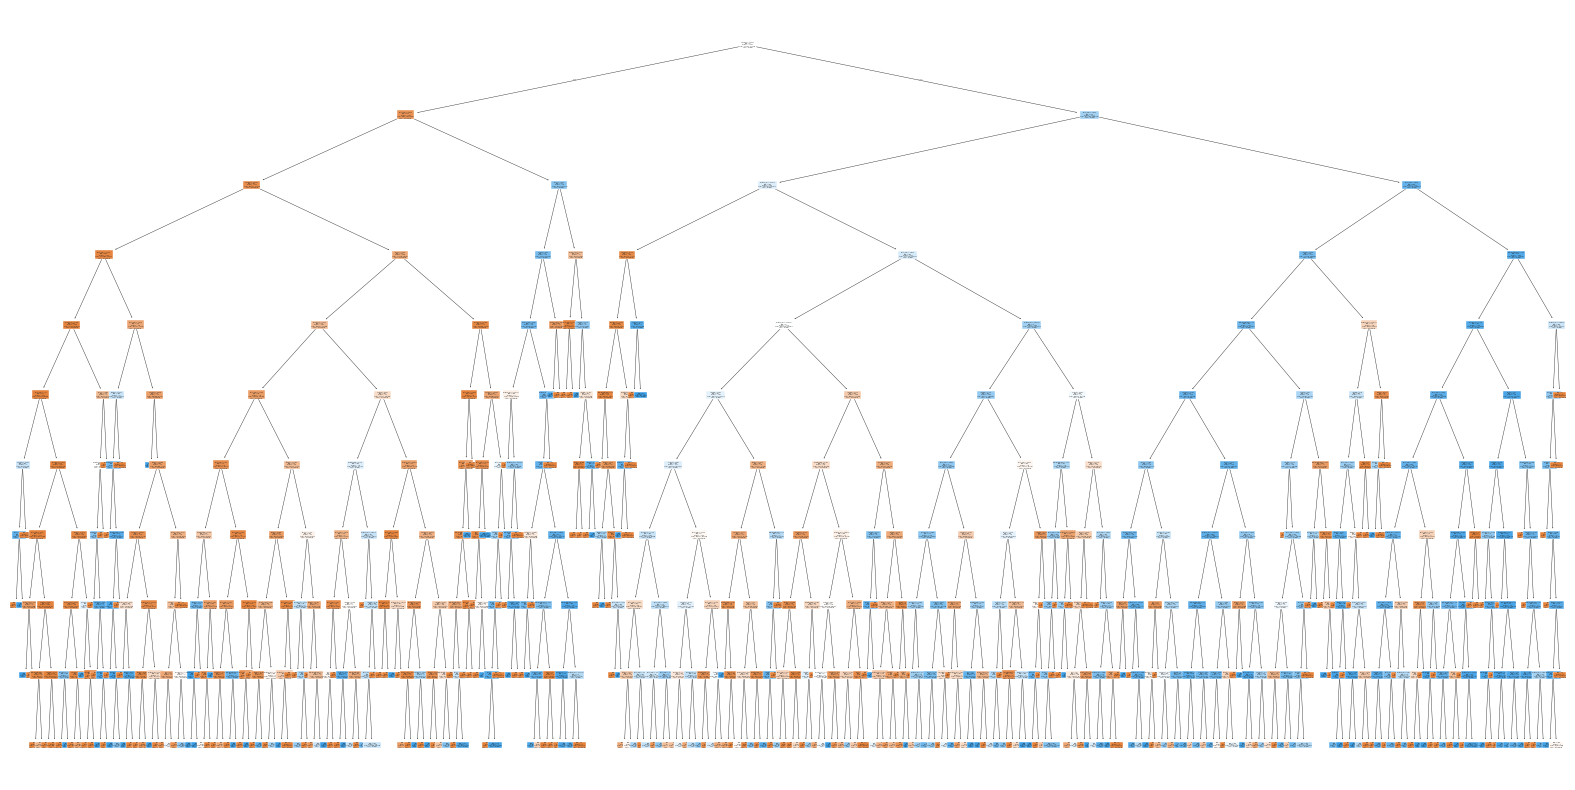

In [ ]:
# @title Vizualizácia stromu
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(tree_model, filled=True, feature_names=train_X.columns, class_names=['Not Popular', 'Popular'])
plt.show()



Strom má veľkú hĺbku a je komplikovaný. To môže byť dôvodom mierneho pretrénovania. Orezanie by mohlo výkon takéhoto komplexného stromu zlepšiť.

In [ ]:
# @title Prerezávanie na základe nákladovej komplexnosti
path = tree_model.cost_complexity_pruning_path(train_X, train_y)
ccp_alphas = path.ccp_alphas  # Rôzne hodnoty alfa pre prerezávanie
impurities = path.impurities  # Súvisiace nečistoty

Cieľom je odstrániť menej dôležité vetvy stromu, ktoré neprinášajú veľkú informačnú hodnotu, a tým znížiť riziko pretrénovania

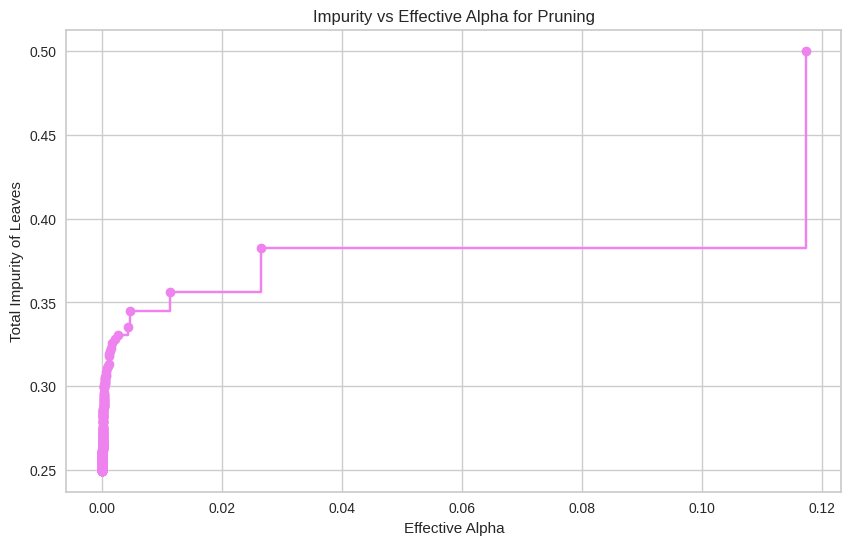

In [ ]:
# Vizualizácia závislosti nečistoty od hodnoty ccp_alpha
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities, marker="o", color="violet", drawstyle="steps-post")
plt.xlabel("Effective Alpha")
plt.ylabel("Total Impurity of Leaves")
plt.title("Impurity vs Effective Alpha for Pruning")
plt.show()

Hľadáme hodnotu alfa, kde strom dosahuje najlepší kompromis medzi nízkou nečistotou a zjednodušením (ideálne bod, kde sa krivka začína výrazne dvíhať). Graf umožňuje vizualizovať, ako rastúca hodnota alfa zvyšuje nečistotu a znižuje komplexnosť stromu.

* Os X - Hodnota alfa, ktorá určuje mieru prerezávania. Čím je hodnota vyššia, tým viac vetiev sa odstráni.
* Os Y - celková nečistota listov stromu. Táto hodnota narastá s rastúcou hodnotou alfa, pretože odstránením vetiev dochádza k zjednodušeniu stromu, ale zároveň k zníženiu schopnosti stromu prispôsobiť sa trénovacím dátam.

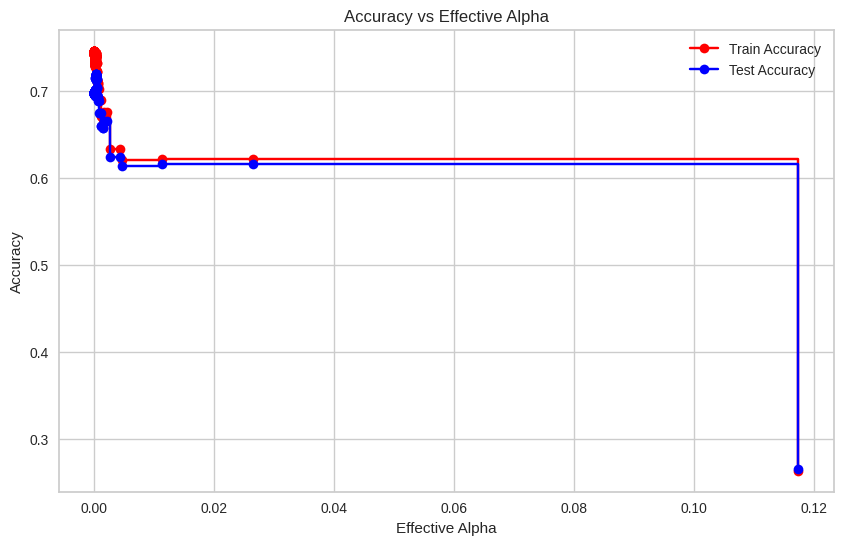

In [ ]:
# Testovanie rôznych hodnôt ccp_alpha
models = []
train_accuracies = []
test_accuracies = []
roc_auc_scores = []  # Uchovávanie AUC skóre
roc_curves = []  # Uchovávanie ROC kriviek (FPR, TPR)

for ccp_alpha in ccp_alphas:
    model = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha, max_depth=10, class_weight='balanced')
    model.fit(train_X, train_y)
    models.append(model)

    # Výpočet presnosti
    train_accuracies.append(accuracy_score(train_y, model.predict(train_X)))
    test_accuracies.append(accuracy_score(test_y, model.predict(test_X)))

    # Výpočet ROC AUC a krivky
    probas = model.predict_proba(test_X)[:, 1]  # Pravdepodobnosti pre pozitívnu triedu
    roc_auc = roc_auc_score(test_y, probas)
    roc_auc_scores.append(roc_auc)

    # Ukladanie ROC krivky
    fpr, tpr, _ = roc_curve(test_y, probas)
    roc_curves.append((fpr, tpr))

# Vizualizácia vplyvu prerezávania na presnosť
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_accuracies, marker="o", label="Train Accuracy", color="red", drawstyle="steps-post")
plt.plot(ccp_alphas, test_accuracies, marker="o", label="Test Accuracy", color="blue", drawstyle="steps-post")
plt.xlabel("Effective Alpha")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Effective Alpha")
plt.show()

Tento graf zobrazuje závislosť medzi hodnotou ccp_alpha (parametra pre prerezávanie rozhodovacieho stromu) a presnosťou modelu na tréningových a testovacích dátach.

* Pri nízkych hodnotách alfa je model pretrénovaný, čo vedie k vysokej presnosti na tréningových dátach, ale slabšej na testovacích.
* Pri veľmi vysokých hodnotách alfa dochádza k underfittingu, keď je strom príliš zjednodušený a nedokáže zachytiť dôležité vzory v dátach.
* Zvolíme hodnotu ccp_alpha v rozsahu 0.01 - 0.03, kde model dosahuje najlepšiu rovnováhu medzi presnosťou na tréningových a testovacích dátach.

In [ ]:
# Výber optimálneho modelu na základe testovacej presnosti
optimal_index = test_accuracies.index(max(test_accuracies))
optimal_alpha = ccp_alphas[optimal_index]
pruned_tree_model = models[optimal_index]

print(f"Optimal ccp_alpha: {optimal_alpha}")
print(f"Test Accuracy of Pruned Tree: {test_accuracies[optimal_index]}")

Optimal ccp_alpha: 0.0003917776803136208
Test Accuracy of Pruned Tree: 0.7196516988219225


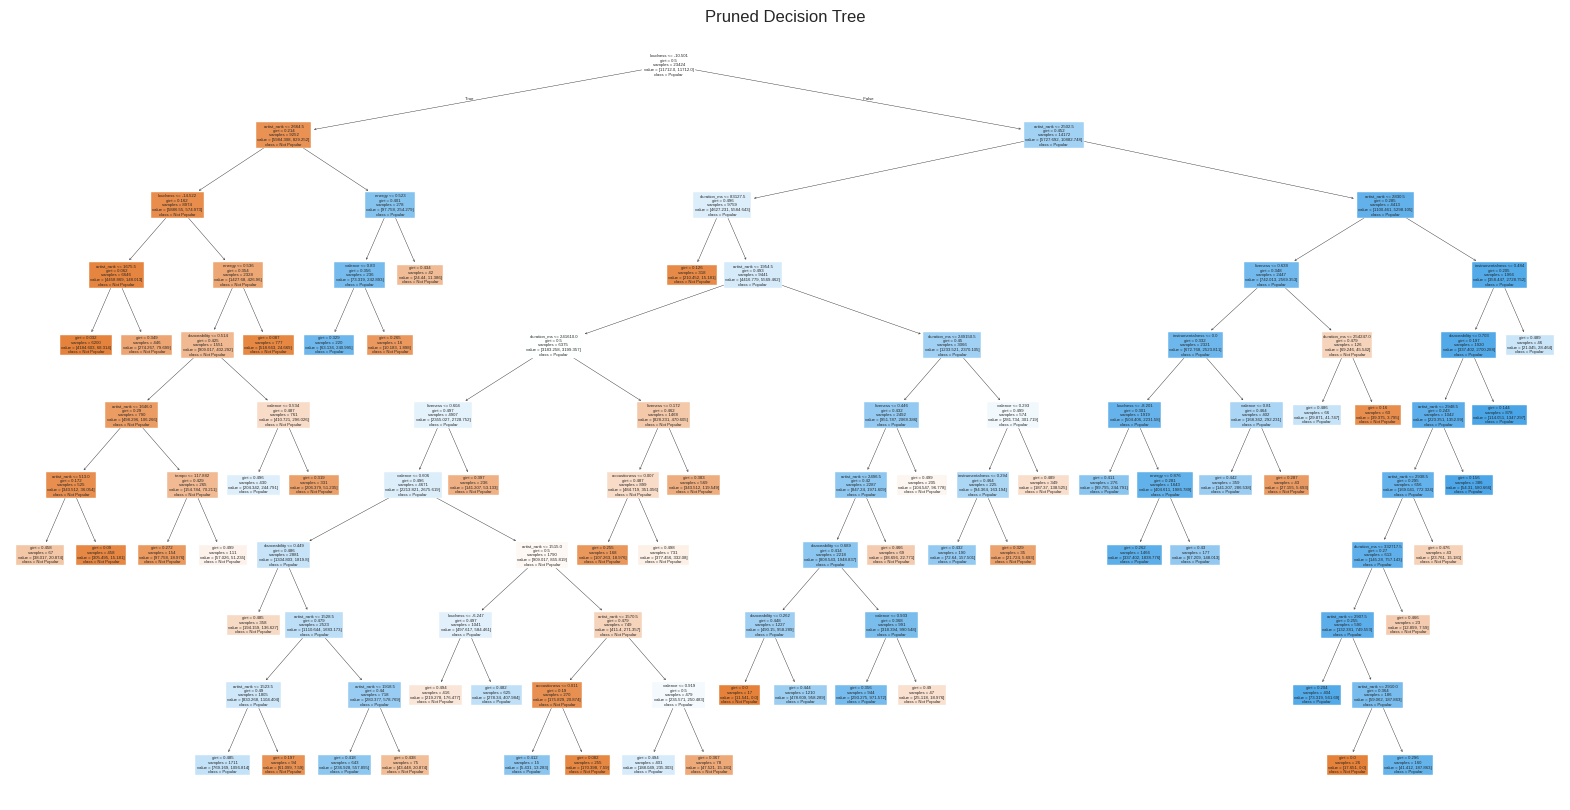

In [ ]:
# Vizualizácia prerezaného stromu
plt.figure(figsize=(20, 10))
plot_tree(pruned_tree_model, filled=True, feature_names=train_X.columns, class_names=['Not Popular', 'Popular'])
plt.title("Pruned Decision Tree")
plt.show()

Prerezaný strom neobsahuje nepodstatné vetvy a zje menej komplexnosný. Výsledkom je model, ktorý je ľahšie interpretovateľný, robustnejší a dúfajme že bude lepšie generalizovať na nové dáta.


In [ ]:
train_predictions = pruned_tree_model.predict(train_X)
test_predictions = pruned_tree_model.predict(test_X)

# Výpočet presnosti na tréningových dátach
train_accuracy = accuracy_score(train_y, train_predictions)
train_confusion = confusion_matrix(train_y, train_predictions)
train_report = classification_report(train_y, train_predictions)

# Výpočet presnosti na testovacích dátach
test_accuracy = accuracy_score(test_y, test_predictions)
test_confusion = confusion_matrix(test_y, test_predictions)
test_report = classification_report(test_y, test_predictions)

# Výpis výsledkov
print(f"Training Accuracy: {train_accuracy}")
print("Confusion Matrix:")
print(train_confusion)
print("Classification Report:")
print(train_report)

print(f"Accuracy: {test_accuracy}")
print("Confusion Matrix:")
print(test_confusion)
print("Classification Report:")
print(test_report)

Training Accuracy: 0.7403944672131147
Confusion Matrix:
[[11994  5258]
 [  823  5349]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.70      0.80     17252
           1       0.50      0.87      0.64      6172

    accuracy                           0.74     23424
   macro avg       0.72      0.78      0.72     23424
weighted avg       0.82      0.74      0.76     23424

Accuracy: 0.7196516988219225
Confusion Matrix:
[[2920 1380]
 [ 262 1295]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.68      0.78      4300
           1       0.48      0.83      0.61      1557

    accuracy                           0.72      5857
   macro avg       0.70      0.76      0.70      5857
weighted avg       0.80      0.72      0.74      5857



In [ ]:
# @title Tabuľka orezaný vs. neorezaný strom výsledky
data = {
    "Metrika": [
        "Tréningová presnosť",
        "Testovacia presnosť",
        "Precision (trieda 1)",
        "Recall (trieda 1)",
        "F1-score (trieda 1)"
    ],
    "Neorezaný strom": ["74.6 %", "69.6 %", "0.46", "0.87", "0.60"],
    "Prerezaný strom": ["74.0 %", "71.9 %", "0.48", "0.83", "0.61"],
    "Zmena": [
        "Mierny pokles v presnosti",
        "Zlepšenie presnosti na testovacích dátach",
        "Mierne zlepšenie",
        "Mierny pokles citlivosti",
        "Mierne zlepšenie"
    ]
}

df = pd.DataFrame(data)
df



Metrika Neorezaný strom Prerezaný strom  \
0   Tréningová presnosť          74.6 %          74.0 %   
1   Testovacia presnosť          69.6 %          71.9 %   
2  Precision (trieda 1)            0.46            0.48   
3     Recall (trieda 1)            0.87            0.83   
4   F1-score (trieda 1)            0.60            0.61   

                                       Zmena  
0                  Mierny pokles v presnosti  
1  Zlepšenie presnosti na testovacích dátach  
2                           Mierne zlepšenie  
3                   Mierny pokles citlivosti  
4                           Mierne zlepšenie

**Závery**
* Prerezaný strom dosahuje vyššiu presnosť na testovacích dátach, čo naznačuje, že sa lepšie generalizuje na nové dáta.
* Prerezaný strom má mierne nižšiu presnosť na tréningových dátach, čo je znakom eliminácie nadmerného prispôsobenia trénovacím dátam.
* F1-score pre populárne skladby sa mierne zlepšilo, čo naznačuje lepší kompromis medzi presnosťou a citlivosťou.
* Prerezanie stromu znížilo citlivosť (recall) pre populárne skladby, ale zlepšilo presnosť a generalizáciu.


<ipython-input-69-3893b165649c>:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color="black")  # Náhodná predikcia


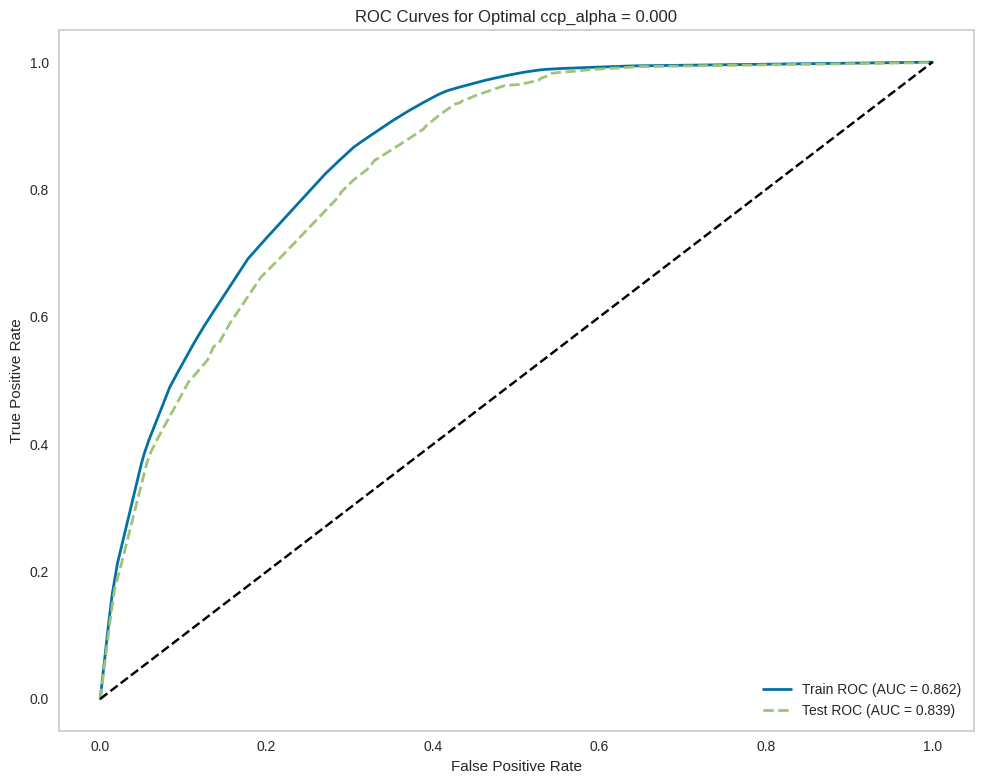

In [ ]:

optimal_index = test_accuracies.index(max(test_accuracies))
optimal_model = models[optimal_index]

# Výpočet pravdepodobností pre tréningové a testovacie dáta
train_probas = optimal_model.predict_proba(train_X)[:, 1]
test_probas = optimal_model.predict_proba(test_X)[:, 1]

# Výpočet ROC kriviek pre tréningové a testovacie dáta
train_fpr, train_tpr, _ = roc_curve(train_y, train_probas)
test_fpr, test_tpr, _ = roc_curve(test_y, test_probas)

# Výpočet AUC skóre
train_auc = roc_auc_score(train_y, train_probas)
test_auc = roc_auc_score(test_y, test_probas)

# Vizualizácia ROC kriviek
plt.figure(figsize=(10, 8))
plt.plot(train_fpr, train_tpr, label=f"Train ROC (AUC = {train_auc:.3f})", linewidth=2)
plt.plot(test_fpr, test_tpr, label=f"Test ROC (AUC = {test_auc:.3f})", linewidth=2, linestyle="--")
plt.plot([0, 1], [0, 1], 'k--', color="black")  # Náhodná predikcia

# Grafické nastavenia
plt.title(f"ROC Curves for Optimal ccp_alpha = {ccp_alphas[optimal_index]:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.legend(loc="lower right")
plt.tight_layout()

plt.show()


* Krivky ROC pre tréningové a testovacie dáta sú podobné. Prerezaný model si zachováva konzistentný výkon na rôznych dátach.
* Prerezaný model je menej komplexný, má menej vetiev a listov, čo znižuje riziko učenia sa šumu v dátach a zlepšuje interpretáciu modelu.
* AUC pre testovaciu množinu: Prerezaný model dosahuje AUC = 0.839, čo je vyššia hodnota v porovnaní s AUC neorezaného modelu (0.808).
* Rozdiel medzi AUC na tréningových dátach (0.862) a testovacích dátach (0.839) je malý, čo ukazuje, že prerezaný model nie je výrazne pretrénovaný.





### Čo by boli ďalšie kroky

Na vylepšenie orezaného stromu, ktorý máme momentálne k dispozícii by sme mohli aplikovať ensemble metódy, ako sú:
* Random Forest,
* Gradient Boosting,
* alebo Bagging,

ktoré kombinujú predikcie viacerých stromov na zlepšenie výkonu modelu.

Tieto metódy by teoreticky:
* dosahovali vyššiu presnosť
* lepšie dokázali zachytiť komplexné vzory v dátach, pretože postupne vytvárajú nové stromy, ktoré opravujú chyby predchádzajúcich stromov (napr. Gradient Boosting).


#3. Porovnanie a Vysledky

V tejto časti sa zameriame na porovnanie výkonnosti vsetkych vyssie naprogramovanych modelov.

Keďže máme  modely, ktoré sa zameriavajú na rôzne typy predikcií – jeden na popularitu ako nebinárnu veličinu a druhý na binárnu hodnotu – budeme tieto dve skupiny hodnotiť samostatne a následne ich porovnáme pomocou presnosti.

In [ ]:
# @title Nebinarna Klasifikacia Popularity
from google.colab import data_table
data = {
    'Model': ['Linearna Regresia', 'KNN'],
    'MSE na test_df': ['256.17', '261.81'],
    'Acuraccy': ['25.7 %', '25.95 %']
}

df = pd.DataFrame(data)
data_table.DataTable(df)


Celkovo by sme zhodnotili kvalitu nebinárnych modelov ako nedostacujucu. Accuracy sa pohubye len okolo 25% pri toleracnii +-5. Avsak ak zvysime toleranciu, tak sa aj vyrazne zvysi accuracy. Preto by tieto modely mohli byt uzitecne aspon pre hruby odhad.

+ jednoducha interpretacia a implmentacia
+ potencial na presne predikovanie pre lepsie datasety
+ mozme pozuit ka je potrebne odhadnut presnu hodnotu
+ mozu ukazat presne vztahy medzi premennymi (regresia)
- slabe pre nekorelovane premenne (nemaju linearne zavisloti)
Accuarcy silno zavisi od skaly predikcii a nastavenej tolerancii.

In [ ]:
# @title Binárna Klasifikácia Popularity

data = {
    'Model': ['Logistická Regresia', 'KNN', 'Rozhodovací Strom'],
    'ROC AUC': ['81%', '83%', '83.9%'],
    'Accuracy': ['73%', '78.62%', '71.9%'],
    'Precision (trieda populárne pesničky)': ['55%', '63%', '48%'],
    'Recall (trieda populárne pesničky)': ['75%', '49%', '83%'],
    'F1-score (trieda populárne pesničky)': ['63%', (2*0.63*0.49) / (0.63+0.49)*100, '61%']
}

df = pd.DataFrame(data)
df

Model ROC AUC Accuracy Precision (trieda populárne pesničky)  \
0  Logistická Regresia     81%      73%                                   55%   
1                  KNN     83%   78.62%                                   63%   
2    Rozhodovací Strom   83.9%    71.9%                                   48%   

  Recall (trieda populárne pesničky) F1-score (trieda populárne pesničky)  
0                                75%                                  63%  
1                                49%                               55.125  
2                                83%                                  61%

Celkovo najvyssiu accuracy a precison dosiahol model KNN. Napriek tomu vsak vyrazne zaostava v hodnote F1 score, ktore kombinuje hodnoty recalla a precision. Tanto paramter povazujeme za doelzity, kedze je nasim cielom spravne predikovat popularne skladby ako popularne. Preto za najvhodnejsie modely povazujeme logisticku regresiu a rozhodovaci strom ,kedze rozdiely medzi nimi su velmi male. Celkovo ich hodnotime ako dobre, vyse 70% skladibe dokazu spravne klasifikovat.

Vyhody
+ jednoducha interpretacia
+ pomerne vysoka presnost

Nevyhody
- zjednodusovanie problemu (strata informacie)
